In [1]:
# OPTIONAL: Load the "autoreload" extension so that code can change
%load_ext autoreload

# OPTIONAL: always reload modules so that as you change code in src, it gets loaded
%autoreload 2

%matplotlib inline

In [2]:
import os, sys
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
sys.path.append("/home/Developer/NCSN-TF2.0/")

import PIL
import utils, configs
import argparse
import seaborn as sns
import pandas as pd
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
import tensorflow_probability as tfp
import matplotlib.pyplot as plt

from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession
from tensorflow.keras import Model, layers
from tensorflow.keras.layers import Input, Flatten, Dense, AvgPool2D

from datasets.dataset_loader import  *
from tqdm import tqdm
from sklearn.metrics import classification_report, average_precision_score
from sklearn.metrics import roc_auc_score, precision_recall_curve, auc

from PIL import Image
from IPython.display import display
from matplotlib.pyplot import imshow
from datetime import datetime

import seaborn as sns
import matplotlib as mpl
sns.set(style="darkgrid")
plt.rcParams['axes.titlesize'] = 18
plt.rcParams['axes.labelsize'] = 16

seed=42
tf.random.set_seed(seed)
np.random.seed(seed)

tf.__version__

'2.3.1'

In [3]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
tf.config.experimental.list_physical_devices('GPU')

Num GPUs Available:  0


[]

In [4]:
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

In [5]:
def get_command_line_args(_args):
    parser = utils._build_parser()

    parser = parser.parse_args(_args)

    utils.check_args_validity(parser)

    print("=" * 20 + "\nParameters: \n")
    for key in parser.__dict__:
        print(key + ': ' + str(parser.__dict__[key]))
    print("=" * 20 + "\n")
    return parser

In [7]:
def metrics(inlier_score, outlier_score, plot=False, verbose=False):
    from sklearn.metrics import roc_curve
    from sklearn.metrics import classification_report, average_precision_score
    from sklearn.metrics import roc_auc_score, precision_recall_curve, auc
    
    y_true = np.concatenate((np.zeros(len(inlier_score)),
                             np.ones(len(outlier_score))))
    y_scores = np.concatenate((inlier_score, outlier_score))
    
    prec,rec,thresh = precision_recall_curve(y_true, y_scores)
    fpr, tpr, thresholds = roc_curve(y_true, y_scores)
    
    roc_auc = roc_auc_score(y_true,y_scores)
    pr_auc = auc(rec,prec)
    ap = average_precision_score(y_true,y_scores)
    
    if plot:    
    
        fig, axs = plt.subplots(1,2, figsize=(16,4))

        sns.lineplot(fpr, tpr, ax=axs[0])
        axs[0].set(
            xlabel="FPR", ylabel="TPR", title="ROC"
        )

        sns.lineplot(rec, prec, ax=axs[1])
        axs[1].set(
            xlabel="Recall", ylabel="Precision", title="Precision-Recall"
        )

        plt.show()
        plt.close()
    
    if verbose:
        print("Inlier vs Outlier")
        print("----------------")
        print("ROC-AUC: {:.4f}".format(roc_auc))
        print("PR-AUC: {:.4f}".format(pr_auc))
        print("Avg Prec: {:.4f}".format(ap))
        
    return roc_auc, ap, pr_auc

In [8]:
from scipy.ndimage import uniform_filter, median_filter

#Smooth first to get rid of spurious outliers
def preproc(x, orig=None):
    x = np.abs(uniform_filter(x, size=3))
    
    # Only consider foreground pixels
#     x = x[orig>0]
    return x

# Selecting Quantile for best separation
def getQuantiles(logits,orig, Q=0.95):    
    quants = [np.quantile(preproc(x,o), Q) for x,o in zip(logits, orig)]
    quants = np.array(quants).reshape(-1,1)
    return quants

## Generating Samples

In [9]:
args = get_command_line_args(["--model=refinenet",
                              "--checkpoint_dir=saved_models/",
                              "--filters=64",
                              "--dataset=seg_brain",
                              "--sigma_low=0.01",
                              "--sigma_high=1",
                              "--y_cond"
                             ])
configs.config_values = args
NUM_L = configs.config_values.num_L
SIGMA_HIGH = configs.config_values.sigma_high
SIGMA_LOW = configs.config_values.sigma_low
BEST_SIGMA_IDX = configs.config_values.num_L - 1
SIGMA_LEVELS = tf.math.exp(tf.linspace(tf.math.log(SIGMA_HIGH),
                                       tf.math.log(SIGMA_LOW),
                                       NUM_L))
SPLITS = utils.dict_splits[configs.config_values.dataset]
SPLITS

Parameters: 

experiment: train
dataset: seg_brain
model: refinenet
filters: 64
num_L: 10
sigma_low: 0.01
sigma_high: 1.0
sigma_sequence: geometric
steps: 200000
learning_rate: 0.001
batch_size: 128
samples_dir: ./samples/
checkpoint_dir: saved_models/
checkpoint_freq: 5000
resume: True
resume_from: -1
init_samples: 
k: 10
eval_setting: sample
ocnn: False
y_cond: True
max_to_keep: 2



(1, 7)

In [9]:
# save_dir, complete_model_name = utils.get_savemodel_dir()
# brain_model_cond, _, step, _,_ = utils.try_load_model(save_dir,
#                                               step_ckpt=configs.config_values.resume_from,
#                                               verbose=True)

In [14]:
args = get_command_line_args(["--model=refinenet",
                              "--checkpoint_dir=saved_models/",
                              "--filters=64",
                              "--dataset=brain",
                              "--sigma_low=0.01",
                              "--sigma_high=1",
                             ])
configs.config_values = args
save_dir, complete_model_name = utils.get_savemodel_dir()
# brain_model, _, step, _,_ = utils.try_load_model(save_dir,
#                                               step_ckpt=configs.config_values.resume_from,
#                                               verbose=True)

Parameters: 

experiment: train
dataset: brain
model: refinenet
filters: 64
num_L: 10
sigma_low: 0.01
sigma_high: 1.0
sigma_sequence: geometric
steps: 200000
learning_rate: 0.001
batch_size: 128
samples_dir: ./samples/
checkpoint_dir: saved_models/
checkpoint_freq: 5000
resume: True
resume_from: -1
init_samples: 
k: 10
eval_setting: sample
ocnn: False
y_cond: False
max_to_keep: 2
split: ['100', '0']



In [11]:
SPLITS

(1, 7)

In [6]:
def load_outlier_data(age="1year"):
    
    DATA_DIR = "/home/Developer/anodetect/data/test/"
    test_paths = glob.glob(DATA_DIR+"/"+age+"/*")
    
    # Create a dictionary describing the features.
    image_feature_description = {
        'image': tf.io.FixedLenFeature([], tf.string),
        'mask': tf.io.FixedLenFeature([], tf.string),
        'segmentation': tf.io.FixedLenFeature([], tf.string),
    }

    @tf.function
    def _parse_record(example_proto):
        # Parse the input tf.Example proto using the dictionary above.
        return tf.io.parse_single_example(example_proto, image_feature_description)

    @tf.function
    def _parse_mri(example_proto):
        
        # Get the record and put it into a feature dict
        image_features = _parse_record(example_proto)
        
        # Deserialize the mri array 
        mri = tf.io.parse_tensor(image_features['image'],
                                out_type=tf.float32)
        mask = tf.io.parse_tensor(image_features['mask'],
                                out_type=tf.float32)
        seg = tf.io.parse_tensor(image_features['segmentation'],
                                out_type=tf.float32)
        
        mri  = tf.expand_dims(mri, axis=-1)
        seg = tf.cast(tf.squeeze(seg), dtype=tf.int32)
        seg = tf.one_hot(seg, depth=7)
#         x = tf.concat((mri,mask,seg), axis=-1)
#         x = tf.concat((mri,seg), axis=-1)
        
        return mri

    test  = tf.data.TFRecordDataset(test_paths).map(_parse_mri)

    return test, len(test_paths)

In [13]:
# import tensorflow.keras as keras

# def build(model):
#     x = [layers.Input(name="images", shape=model.in_shape[0][1:]),
#                  layers.Input(name="idx_sigmas", shape=(), dtype=tf.int32)]
#     return keras.Model(inputs=x, outputs=model.call(x))

# m= build(brain_model)
# m.summary()

In [12]:
brain_model

In [13]:
SIGMAS = utils.get_sigma_levels().numpy()

> ### Note that since we do not have masks, background values are not exactly zero
> ### Use an eps instead (default: 1e-10)

In [7]:
@tf.function
def perturb(x):
    x_batch, y_cond = tf.split(x, SPLITS, axis=-1)
    perturbation =  tf.random.normal(shape=x_batch.shape, mean=0, stddev=SIGMA_VALUE)
    x_perturbed = x_batch + perturbation
    x = tf.concat((x_perturbed, y_cond), axis=-1)
    return x

@tf.function
def score_batch(x_batch):
#     x_batch = perturb(x_batch)
    score = brain_model([x_batch, idx_sigmas])
    return score

In [8]:
@tf.function
def remove_segs(x):
    x, segs = tf.split(x, SPLITS, axis=-1)
    return x

In [16]:
# Test Samples in ABCD
min_size = 900
x_outliers = []
ages = ["1year", "2year", "4year", "6year"]
for age in ages[0:]:
    x_outlier, test_size = load_outlier_data(age)
    x_outliers.append(x_outlier)
    if min_size > test_size:
        min_size = test_size
    print(test_size)
print("Choosing Sample Size:", min_size)

756
582
519
570
Choosing Sample Size: 519


In [20]:
## Saving to Numpy

In [9]:
%%time
ages = ["1year", "2year", "4year", "6year"]
outlier_datasets = []
for age in ages:
    x_outlier, test_size = load_outlier_data(age)
    print(age, test_size)
    batch_size = test_size
    
    x_outlier = x_outlier.shuffle(1000)
    x_outlier = x_outlier.batch(batch_size)
    outlier_datasets.append(x_outlier)

1year 756
2year 582
4year 519
6year 570
CPU times: user 636 ms, sys: 55.9 ms, total: 692 ms
Wall time: 1.55 s


In [12]:
for age,ds in zip(ages[0:], outlier_datasets[0:]):
    x = next(iter(ds)).numpy()
    labels = np.ones(x.shape[0]) * int(age[0]) 
    dirname = "/home/Developer/genomics_ood/images_ood/image_data/"
    dirname="./"
    fname = dirname+"brain_"+age+".npy"

    with tf.compat.v1.gfile.Open(fname, 'wb') as f:
        np.save(f, x)
        np.save(f, labels)

In [ ]:
### DO THESE

In [42]:
x = next(iter(outlier_datasets[0])).numpy()
datadir = "/home/Developer/genomics_ood/images_ood/image_data/"
with open(datadir+"brain_ood.npy", "wb") as f:
    labels = np.ones(200) * int(1)
    np.save(f,x[:200])
    np.save(f, labels)
    
with open(datadir+"brain_1year.npy", "wb") as f:
    labels = np.ones(x[200:].shape[0]) * int(1)
    np.save(f,x[200:])
    np.save(f, labels)

In [41]:
x[200:].shape

(370, 91, 109, 1)

In [24]:
x_train, x_test =  get_train_test_data("brain")
x_train = x_train.batch(10500)
x_test = x_test.batch(1137)
# x_val = x_test_.skip(1000).batch(137)
# x_test = x_test_.take(1000).batch(1000)

Split: ['train', 'test']


In [25]:
train_data = {
    "images":[],
    "labels": []
}

# test_data = {
#     "images": []
#     "labels": []
# }

for age,ds in zip(ages, outlier_datasets):
    x = next(iter(ds)).numpy()
    labels = np.ones(x.shape[0]) * int(age[0])
    
    train_data["images"].append(x)
    train_data["labels"].append(labels)

for n,ds in zip(["train","test"], [x_train, x_test]):
    x = next(iter(ds)).numpy()
    labels = np.ones(x.shape[0]) * int(0)
    
    train_data["images"].append(x)
    train_data["labels"].append(labels)

train_data["images"] = np.concatenate(train_data["images"], axis=0)
train_data["labels"] = np.concatenate(train_data["labels"], axis=0)

In [26]:
with open("brain_train_data.p", "wb") as f:
    pickle.dump(train_data, f)

In [31]:
!du -sh ./*

29M	./brain_1year.npy
23M	./brain_2year.npy
20M	./brain_4year.npy
22M	./brain_6year.npy
8.0K	./brain_classifier.ipynb
576K	./brain_scores.p
38M	./brain_test.npy
398M	./brain_train.npy
1.0G	./brain_train_data.p
5.2M	./brain_val.npy
212K	./gmm_curves.png
384K	./gmm_scores.png
940K	./ood_analysis.ipynb
4.1M	./score_classifier_brain-8yr.ipynb
4.8M	./score_classifier_brain.ipynb
3.3M	./viz_brain_1-2.ipynb
4.3M	./viz_brain_4-6.ipynb


In [ ]:
# with tf.compat.v1.gfile.Open(
#   os.path.join(out_dir, '%s_%s.npy' % (name, subset)), 'wb') as f:
# np.save(f, images_np)
# np.save(f, labels_np)

In [45]:
for n,ds in zip(["train","val","test"], [x_train, x_val, x_test]):
    
    x = next(iter(ds)).numpy()
    labels = np.ones(x.shape[0]) * int(0)
    fname=datadir+"brain_"+n+".npy"
    with tf.compat.v1.gfile.Open(fname, 'wb') as f:
        np.save(f,x)
        np.save(f, labels)

In [24]:
!ls /home/Developer/anodetect/data/processed/images/train | wc -l
!ls /home/Developer/anodetect/data/processed/images/test | wc -l

10500
1137


In [31]:
!du -sh ./*

29M	./brain_1year.npy
23M	./brain_2year.npy
20M	./brain_4year.npy
22M	./brain_6year.npy
576K	./brain_scores.p
64M	./brain_test.npy
512M	./brain_train.npy
7.6M	./brain_val.npy
212K	./gmm_curves.png
384K	./gmm_scores.png
940K	./ood_analysis.ipynb
4.1M	./score_classifier_brain-8yr.ipynb
4.8M	./score_classifier_brain.ipynb
3.3M	./viz_brain_1-2.ipynb
4.3M	./viz_brain_4-6.ipynb


In [31]:
%%time
# TEST_BATCH=min_size//10
# BATCH_COUNT = test_size // TEST_BATCH
# print("Testing {} batches of {}: {} samples".format(BATCH_COUNT, TEST_BATCH, TEST_BATCH*BATCH_COUNT))

ages = ["1year", "2year", "4year", "6year"]
outlier_datasets = []
for age in ages:
    x_outlier, test_size = load_outlier_data(age)
    print(age, test_size)
    batch_count = 10
    batch_size = test_size // batch_count
    
    x_outlier = x_outlier.shuffle(1000)
    x_outlier = x_outlier.map(remove_segs)
    x_outlier = x_outlier.batch(batch_size).take(batch_count).prefetch(tf.data.experimental.AUTOTUNE).cache()
    outlier_datasets.append(x_outlier)

1year 756
2year 582
4year 519
6year 570
CPU times: user 188 ms, sys: 33.1 ms, total: 221 ms
Wall time: 218 ms


### Getting train/test inlier distributions

In [32]:
!ls /home/Developer/anodetect/data/processed/images/test | wc -l

1137


In [33]:
x_train_, x_test_ =  get_train_test_data("seg_brain")
x_test_ = x_test_.map(remove_segs).batch(200)

x_train = x_train_.map(remove_segs).batch(256).prefetch(tf.data.experimental.AUTOTUNE)

inlier_batches = [x for x in x_test_]
len(inlier_batches), [x.shape[0] for x in inlier_batches]

(6, [200, 200, 200, 200, 200, 137])

## Mixing Scores

In [34]:
def compute_scores(x_test):
    
    # Sigma Idx -> Score
    score_dict = []
    
    sigmas = utils.get_sigma_levels().numpy()
    final_logits = 0 #tf.zeros(logits_shape)
    progress_bar = tqdm(SIGMAS, desc='Sigma: ?')
    for idx, sigma in enumerate(progress_bar):
        
        progress_bar.set_description("Sigma: {:.4f}".format(sigma))
        _logits =[]

        for x_batch in x_test:
            idx_sigmas = tf.ones(x_batch.shape[0], dtype=tf.int32) * idx
            score = brain_model([x_batch, idx_sigmas])
#             x_batch, y_cond = tf.split(x_batch, SPLITS, axis=-1)
#             score = tf.where(x_batch > 1e-10, score,  0)
            _logits.append(score)

        _logits = tf.concat(_logits, axis=0)
        score_dict.append(tf.identity(_logits))
        
#         final_logits += _logits * sigma
    
    return score_dict

In [35]:
%%time
train_dist = compute_scores(x_train)

Sigma: 0.0100: 100%|██████████| 10/10 [14:20<00:00, 86.08s/it]

CPU times: user 5min 49s, sys: 7min 32s, total: 13min 22s
Wall time: 14min 20s


In [ ]:
%%time
inlier_dist = compute_scores(inlier_batches)

In [36]:
%%time
outlier_dists = []
for outlier in outlier_datasets:
    outlier_dists.append(compute_scores(outlier))

Sigma: 0.0100: 100%|██████████| 10/10 [00:50<00:00,  5.04s/it]

CPU times: user 1min 40s, sys: 34.5 s, total: 2min 14s
Wall time: 3min 55s


### Original Separation

In [139]:
# L2-norm same as Frobenius
train_score = tf.norm(train_dist[-1], axis=[1,2], ord="euclidean").numpy()
inlier_score =  tf.norm(inlier_dist[-1], axis=[1,2], ord="euclidean").numpy()
outlier_scores = []

for _dists in outlier_dists:
    outlier_scores.append(tf.norm(_dists[-1], axis=[1,2], ord="euclidean").numpy())
    
# outlier_scores = np.stack(outlier_scores)

In [140]:
[x[:len(inlier_score)].shape for x in outlier_scores]

[(337, 1), (337, 1), (337, 1), (337, 1)]

In [150]:
LABELS = ["Train", "ABCD"] + ages

df = pd.DataFrame(np.concatenate((train_score[:len(inlier_score)],
                                  inlier_score, 
                                  *[x[:len(inlier_score)] for x in outlier_scores]), axis=-1),
             columns=LABELS)
df.describe()

Train         ABCD        1year        2year        4year  \
count   337.000000   337.000000   337.000000   337.000000   337.000000   
mean   2915.501465  2999.365479  2765.538574  2751.281006  2867.422607   
std     204.064072   174.023926   255.242920   246.916992   241.553497   
min    2251.434814  2527.486328  2233.899170  2205.063232  2244.531738   
25%    2791.664795  2881.062744  2577.329346  2566.734619  2695.978516   
50%    2901.759033  2986.826660  2746.291260  2736.585205  2886.389160   
75%    3024.722412  3094.465332  2923.224854  2932.084717  3047.484375   
max    3775.828613  3650.277100  3461.829346  3393.421631  3408.422119   

             6year  
count   337.000000  
mean   2922.146484  
std     219.168076  
min    2188.776123  
25%    2803.489990  
50%    2945.276855  
75%    3087.510986  
max    3385.172852

In [198]:
mpl.rcParams['figure.dpi'] = 300
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['axes.labelsize'] = 18

In [ ]:
fig, axs = plt.subplots(1,10, figsize=(20,4))

for idx in range(10):
    axs[idx].imshow(inlier_dist[0][idx].numpy()[...,-1], cmap="RdGy")
    axs[idx].grid(False)
    axs[idx].axis("off")
    axs[idx].set_title("S{}".format(idx))
# plt.show()

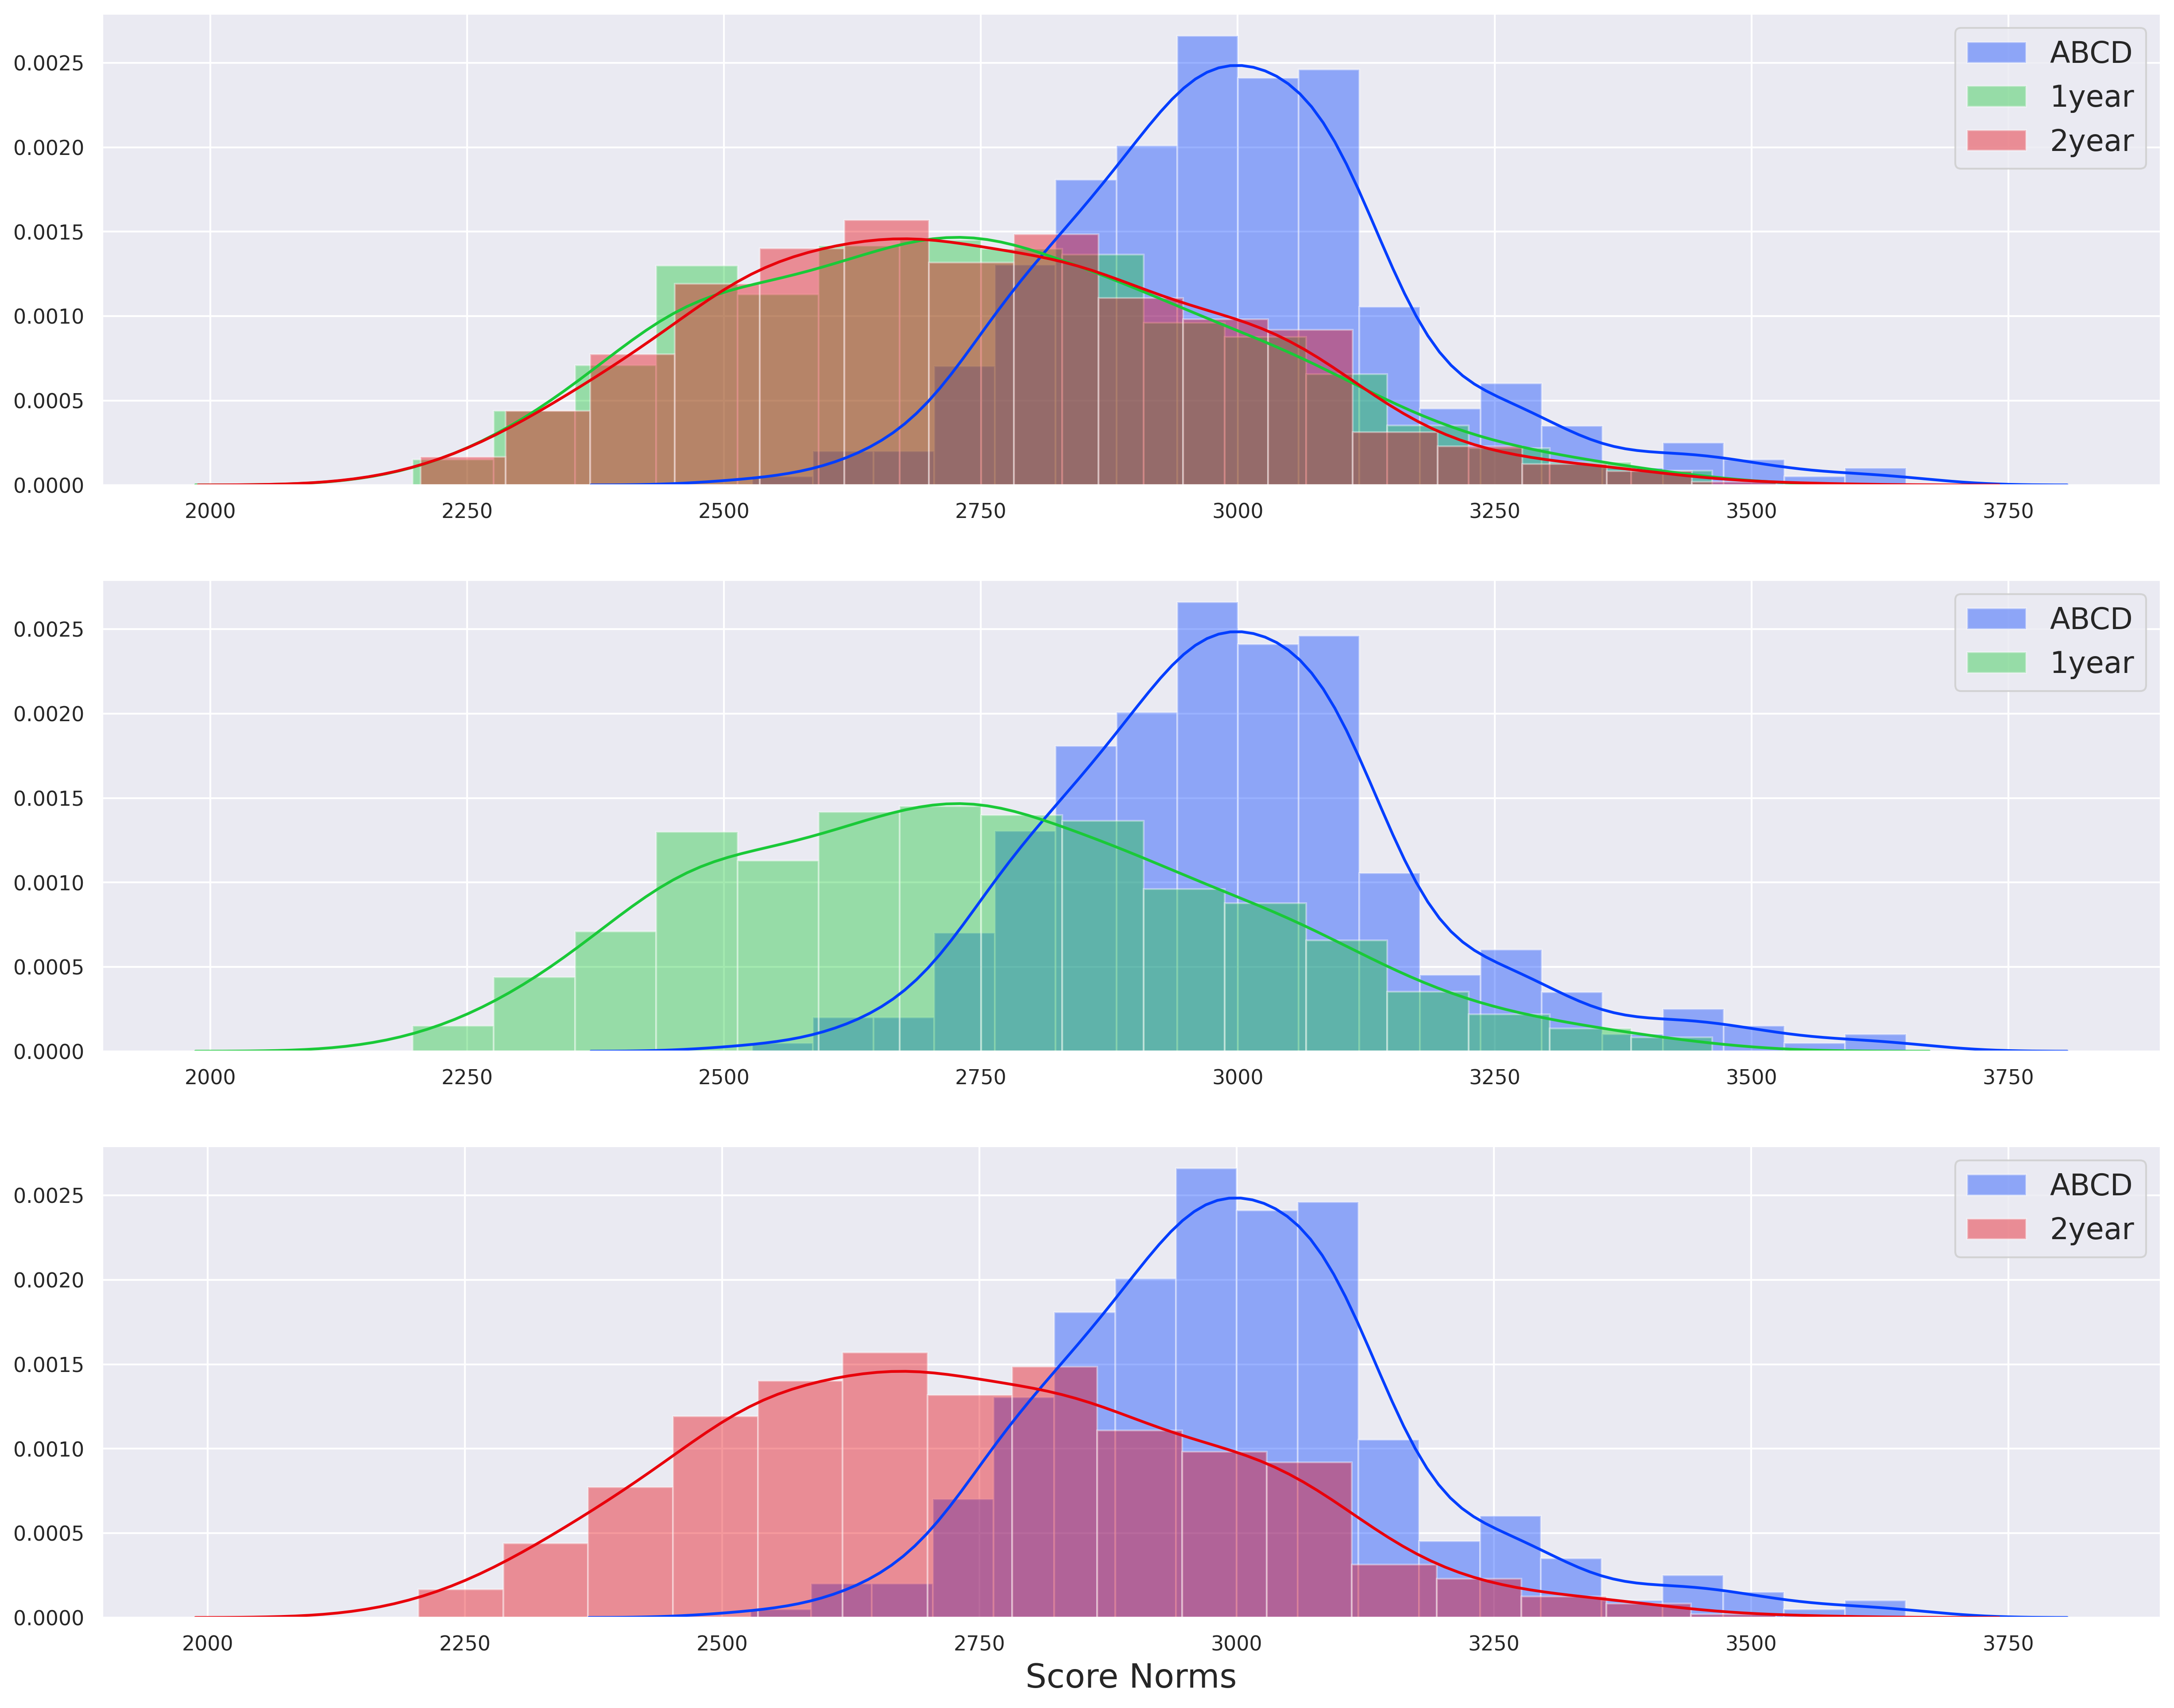

In [164]:
COLORS = sns.color_palette("bright")
# COLORS[0] = "blue" 
# COLORS[1] = "red" 

fig, axs = plt.subplots(3,1, figsize=(20,16))

# sns.distplot(train_score, color=COLORS[0], label=LABELS[0], ax=axs[0])
sns.distplot(inlier_score, color=COLORS[0], label=LABELS[1], ax=axs[0])

for idx, _score in enumerate(outlier_scores[:2]):
    idx += 2
    sns.distplot(_score, color=COLORS[idx], label=LABELS[idx], ax=axs[0])

sns.distplot(inlier_score, color=COLORS[0], label=LABELS[1], ax=axs[1])
for idx, _score in enumerate(outlier_scores[:1]):
    idx += 2
    sns.distplot(_score, color=COLORS[idx], label=LABELS[idx], ax=axs[1])    

sns.distplot(inlier_score, color=COLORS[0], label=LABELS[1], ax=axs[2])
for idx, _score in enumerate(outlier_scores[1:2]):
    idx += 3
    sns.distplot(_score, color=COLORS[idx], label=LABELS[idx], ax=axs[2])

for ax in axs: ax.legend(fontsize=16)
axs[-1].set(xlabel="Score Norms")
plt.show()

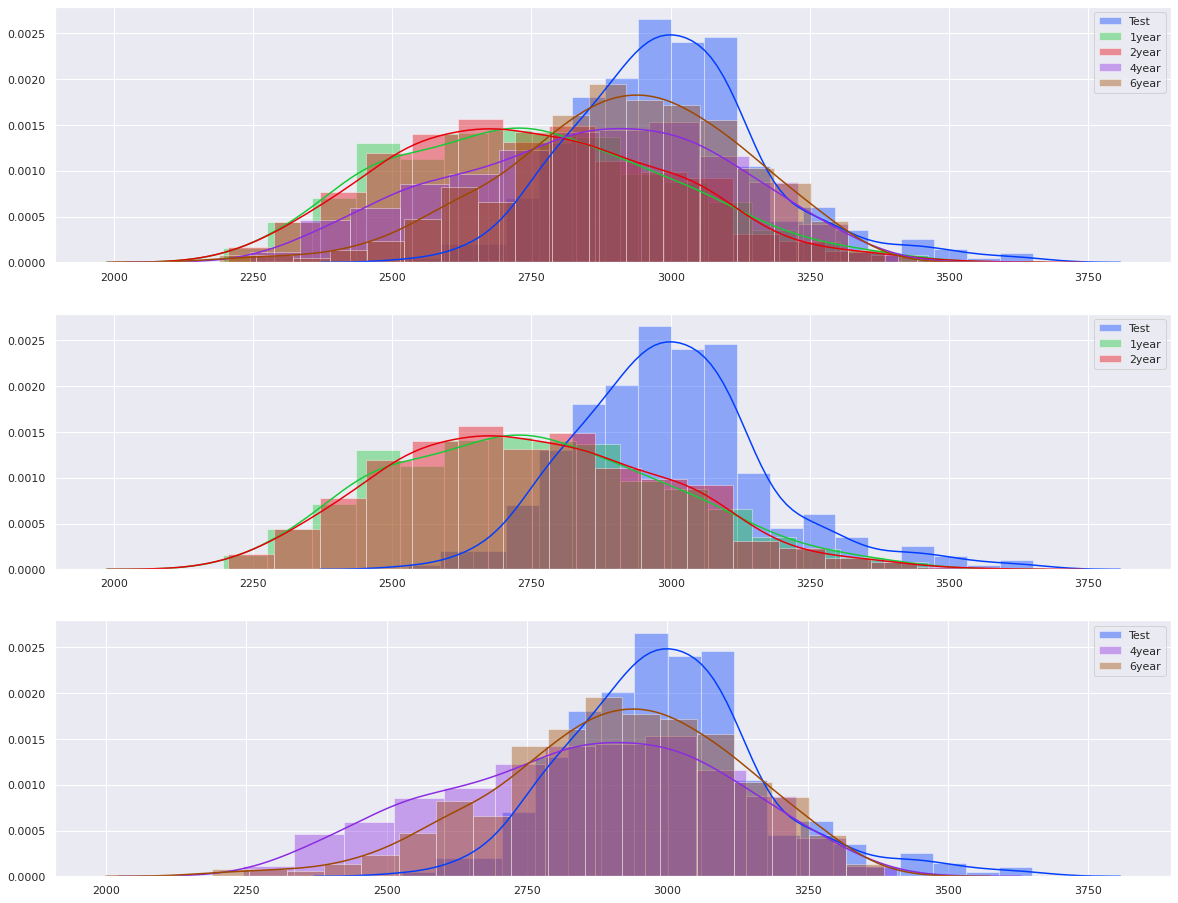

In [145]:
COLORS = sns.color_palette("bright")
# COLORS[0] = "blue" 
# COLORS[1] = "red" 

fig, axs = plt.subplots(3,1, figsize=(20,16))

# sns.distplot(train_score, color=COLORS[0], label=LABELS[0], ax=axs[0])
sns.distplot(inlier_score, color=COLORS[0], label=LABELS[1], ax=axs[0])

for idx, _score in enumerate(outlier_scores):
    idx += 2
    sns.distplot(_score, color=COLORS[idx], label=LABELS[idx], ax=axs[0])

sns.distplot(inlier_score, color=COLORS[0], label=LABELS[1], ax=axs[1])
for idx, _score in enumerate(outlier_scores[:2]):
    idx += 2
    sns.distplot(_score, color=COLORS[idx], label=LABELS[idx], ax=axs[1])    

sns.distplot(inlier_score, color=COLORS[0], label=LABELS[1], ax=axs[2])
for idx, _score in enumerate(outlier_scores[2:]):
    idx += 4
    sns.distplot(_score, color=COLORS[idx], label=LABELS[idx], ax=axs[2])

for ax in axs: ax.legend()
plt.show()

### Mixing Scores

In [170]:
# L2-norm same as Frobenius
train_agg = tf.add_n([inlier_train_dist[x] * s for x, s in enumerate(SIGMAS)])
inlier_agg = tf.add_n([inlier_dist[x] * s for x, s in enumerate(SIGMAS)])
train_score = tf.norm(train_agg, axis=[1,2], ord="euclidean").numpy()
inlier_score = tf.norm(inlier_agg, axis=[1,2], ord="euclidean").numpy()

outlier_scores = []
for _dists in outlier_dists:
    weighted_sum = tf.add_n([_dists[x] * s for x,s in enumerate(SIGMAS)])
    outlier_scores.append(tf.norm(weighted_sum, axis=[1,2], ord="euclidean").numpy())
    
# outlier_scores = np.stack(outlier_scores)

In [133]:
[x[:len(inlier_score)].shape for x in outlier_scores]

[(337, 1), (337, 1), (337, 1), (337, 1)]

In [171]:
LABELS = ["Train", "ABCD"] + ages

df = pd.DataFrame(np.concatenate((train_score[:len(inlier_score)],
                                  inlier_score, 
                                  *[x[:len(inlier_score)] for x in outlier_scores]), axis=-1),
             columns=LABELS)
df.describe()

Train        ABCD       1year       2year       4year       6year
count  337.000000  337.000000  337.000000  337.000000  337.000000  337.000000
mean   353.830017  354.139587  371.613861  365.208923  364.536835  358.323853
std     12.753666   11.292300   14.997336   13.278090   23.957811   23.507698
min    321.202728  327.018066  330.213715  327.297577  308.700409  312.107697
25%    344.756470  346.642303  362.407623  356.486938  344.678711  340.749512
50%    353.921539  353.088837  372.471252  365.731995  360.097168  353.947662
75%    361.872833  360.531311  381.804840  374.033600  383.372040  374.051544
max    404.612152  384.553894  411.014038  402.107910  432.681549  434.966034

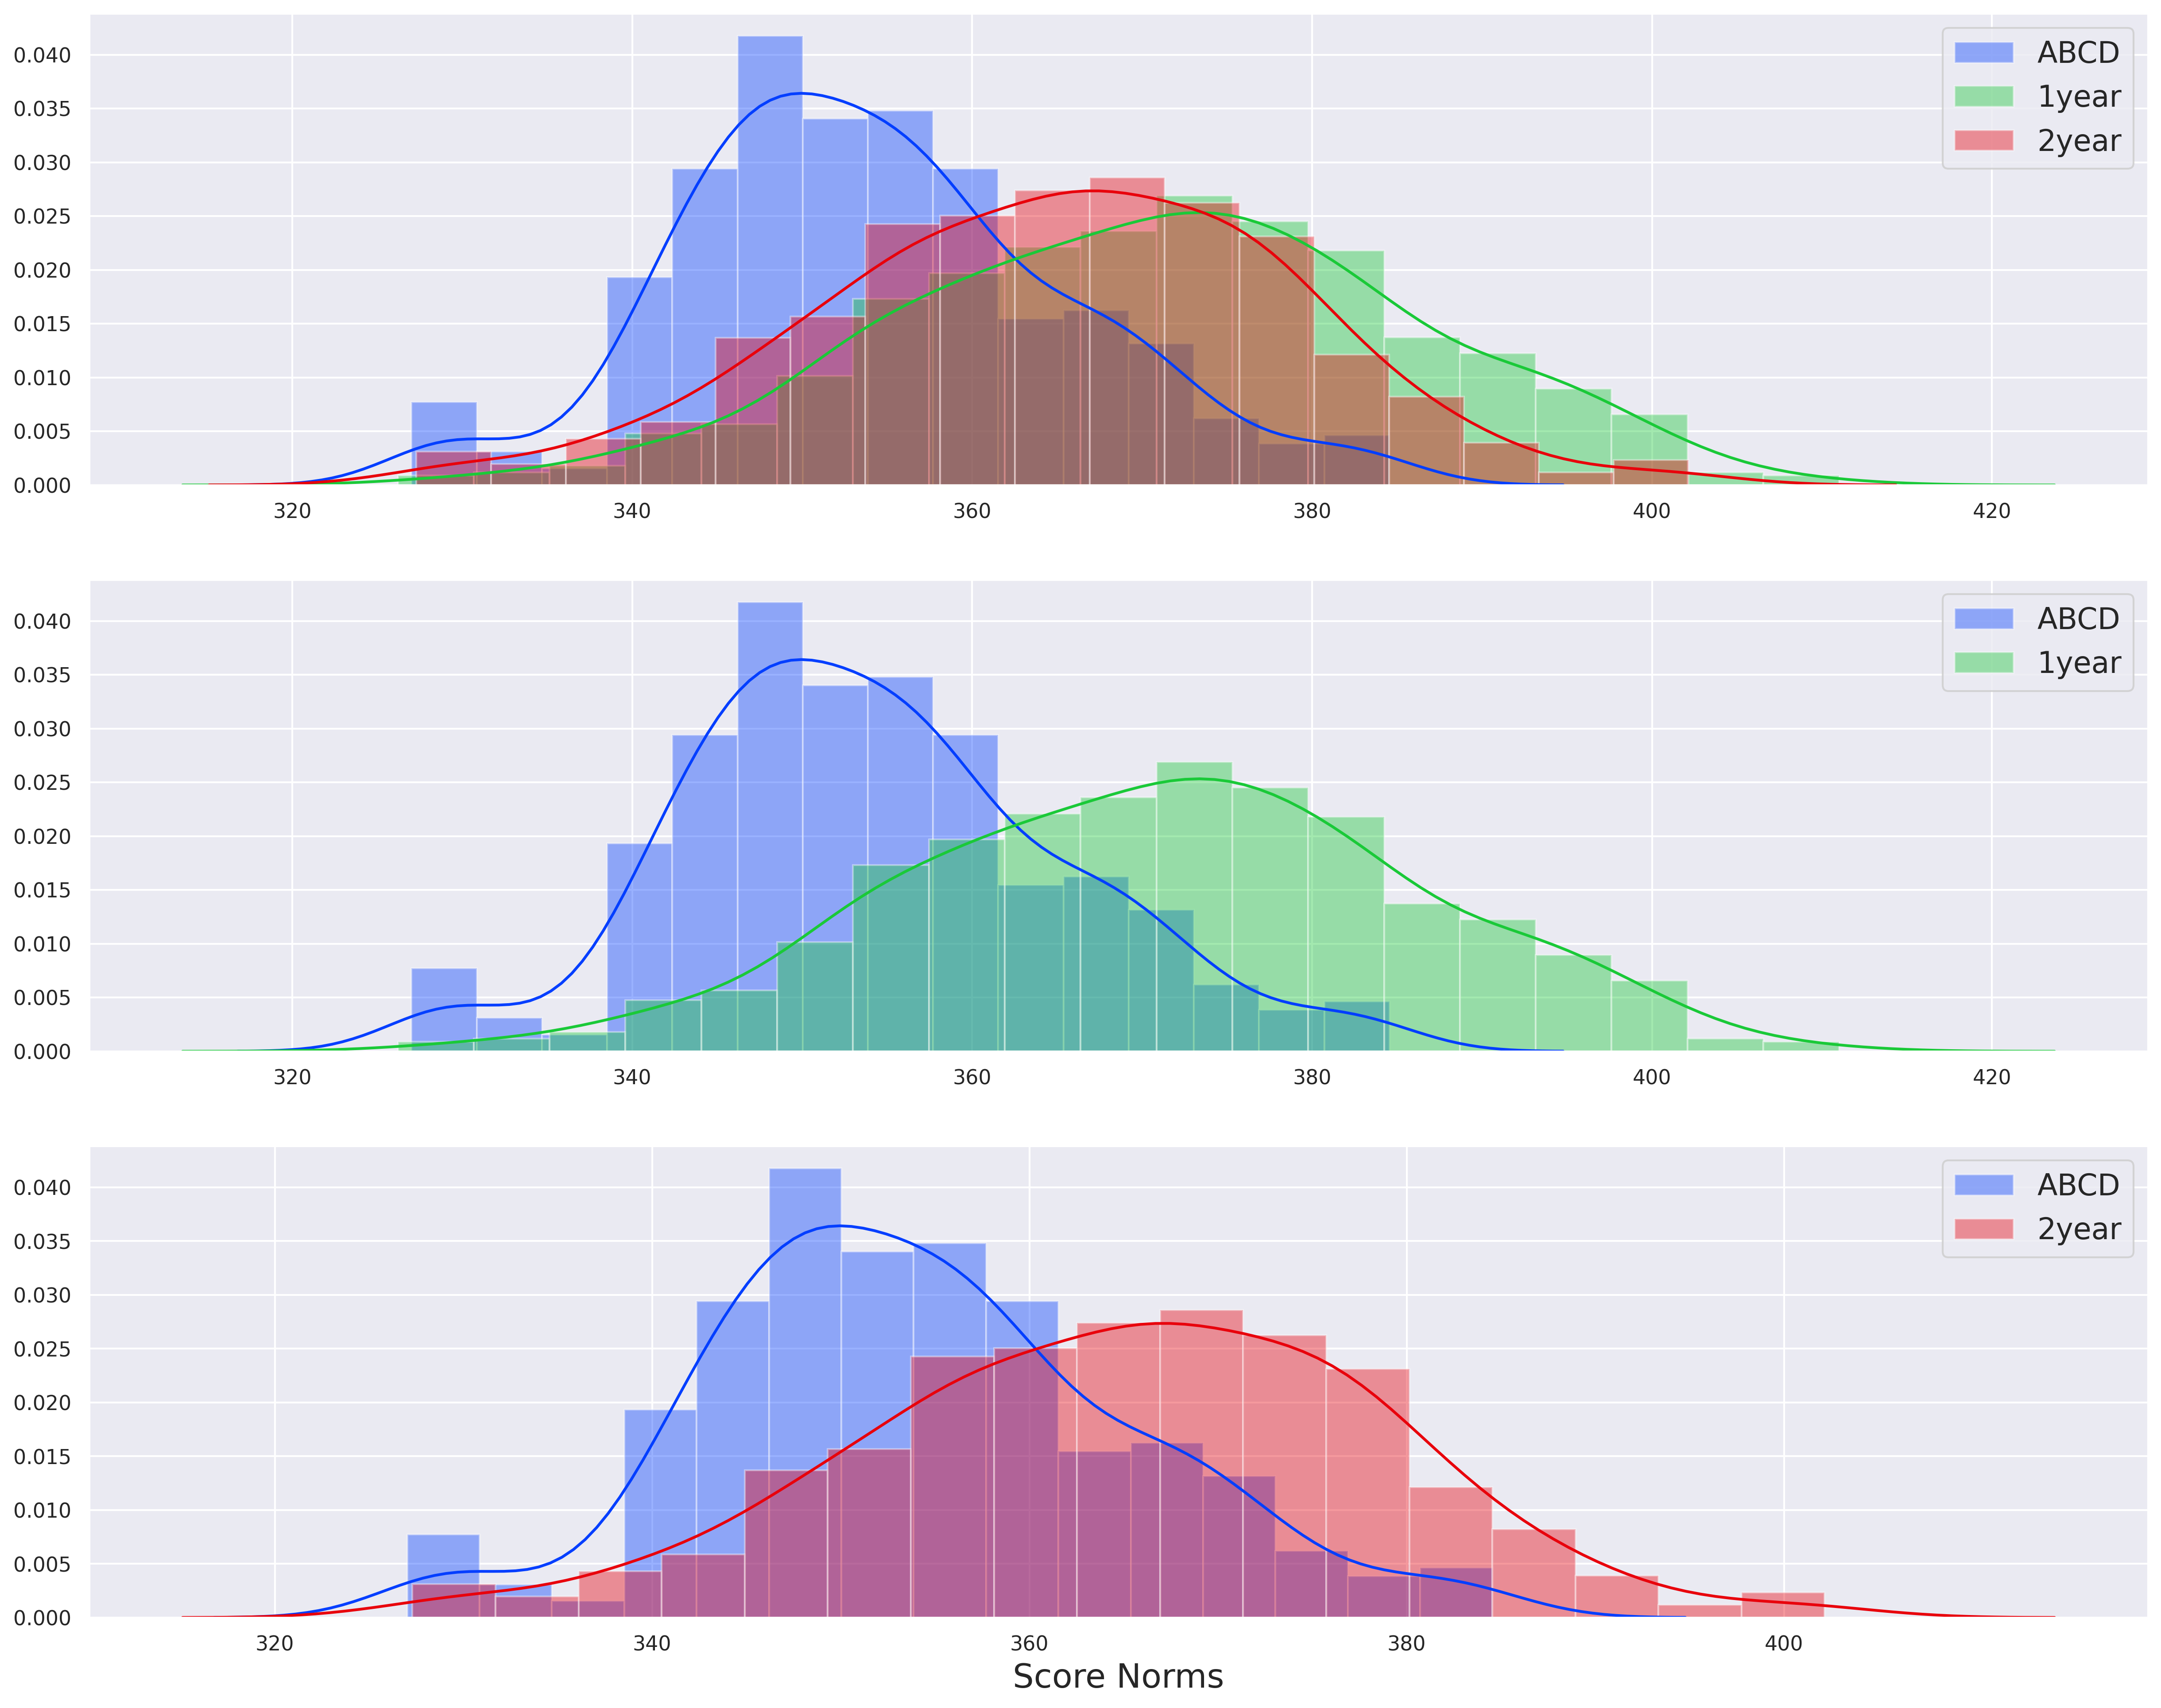

In [172]:
COLORS = sns.color_palette("bright")
# COLORS[0] = "blue" 
# COLORS[1] = "red" 

fig, axs = plt.subplots(3,1, figsize=(20,16))

# sns.distplot(train_score, color=COLORS[0], label=LABELS[0], ax=axs[0])
sns.distplot(inlier_score, color=COLORS[0], label=LABELS[1], ax=axs[0])

for idx, _score in enumerate(outlier_scores[:2]):
    idx += 2
    sns.distplot(_score, color=COLORS[idx], label=LABELS[idx], ax=axs[0])

sns.distplot(inlier_score, color=COLORS[0], label=LABELS[1], ax=axs[1])
for idx, _score in enumerate(outlier_scores[:1]):
    idx += 2
    sns.distplot(_score, color=COLORS[idx], label=LABELS[idx], ax=axs[1])    

sns.distplot(inlier_score, color=COLORS[0], label=LABELS[1], ax=axs[2])
for idx, _score in enumerate(outlier_scores[1:2]):
    idx += 3
    sns.distplot(_score, color=COLORS[idx], label=LABELS[idx], ax=axs[2])

for ax in axs: ax.legend(fontsize=16)
axs[-1].set(xlabel="Score Norms")
plt.show()

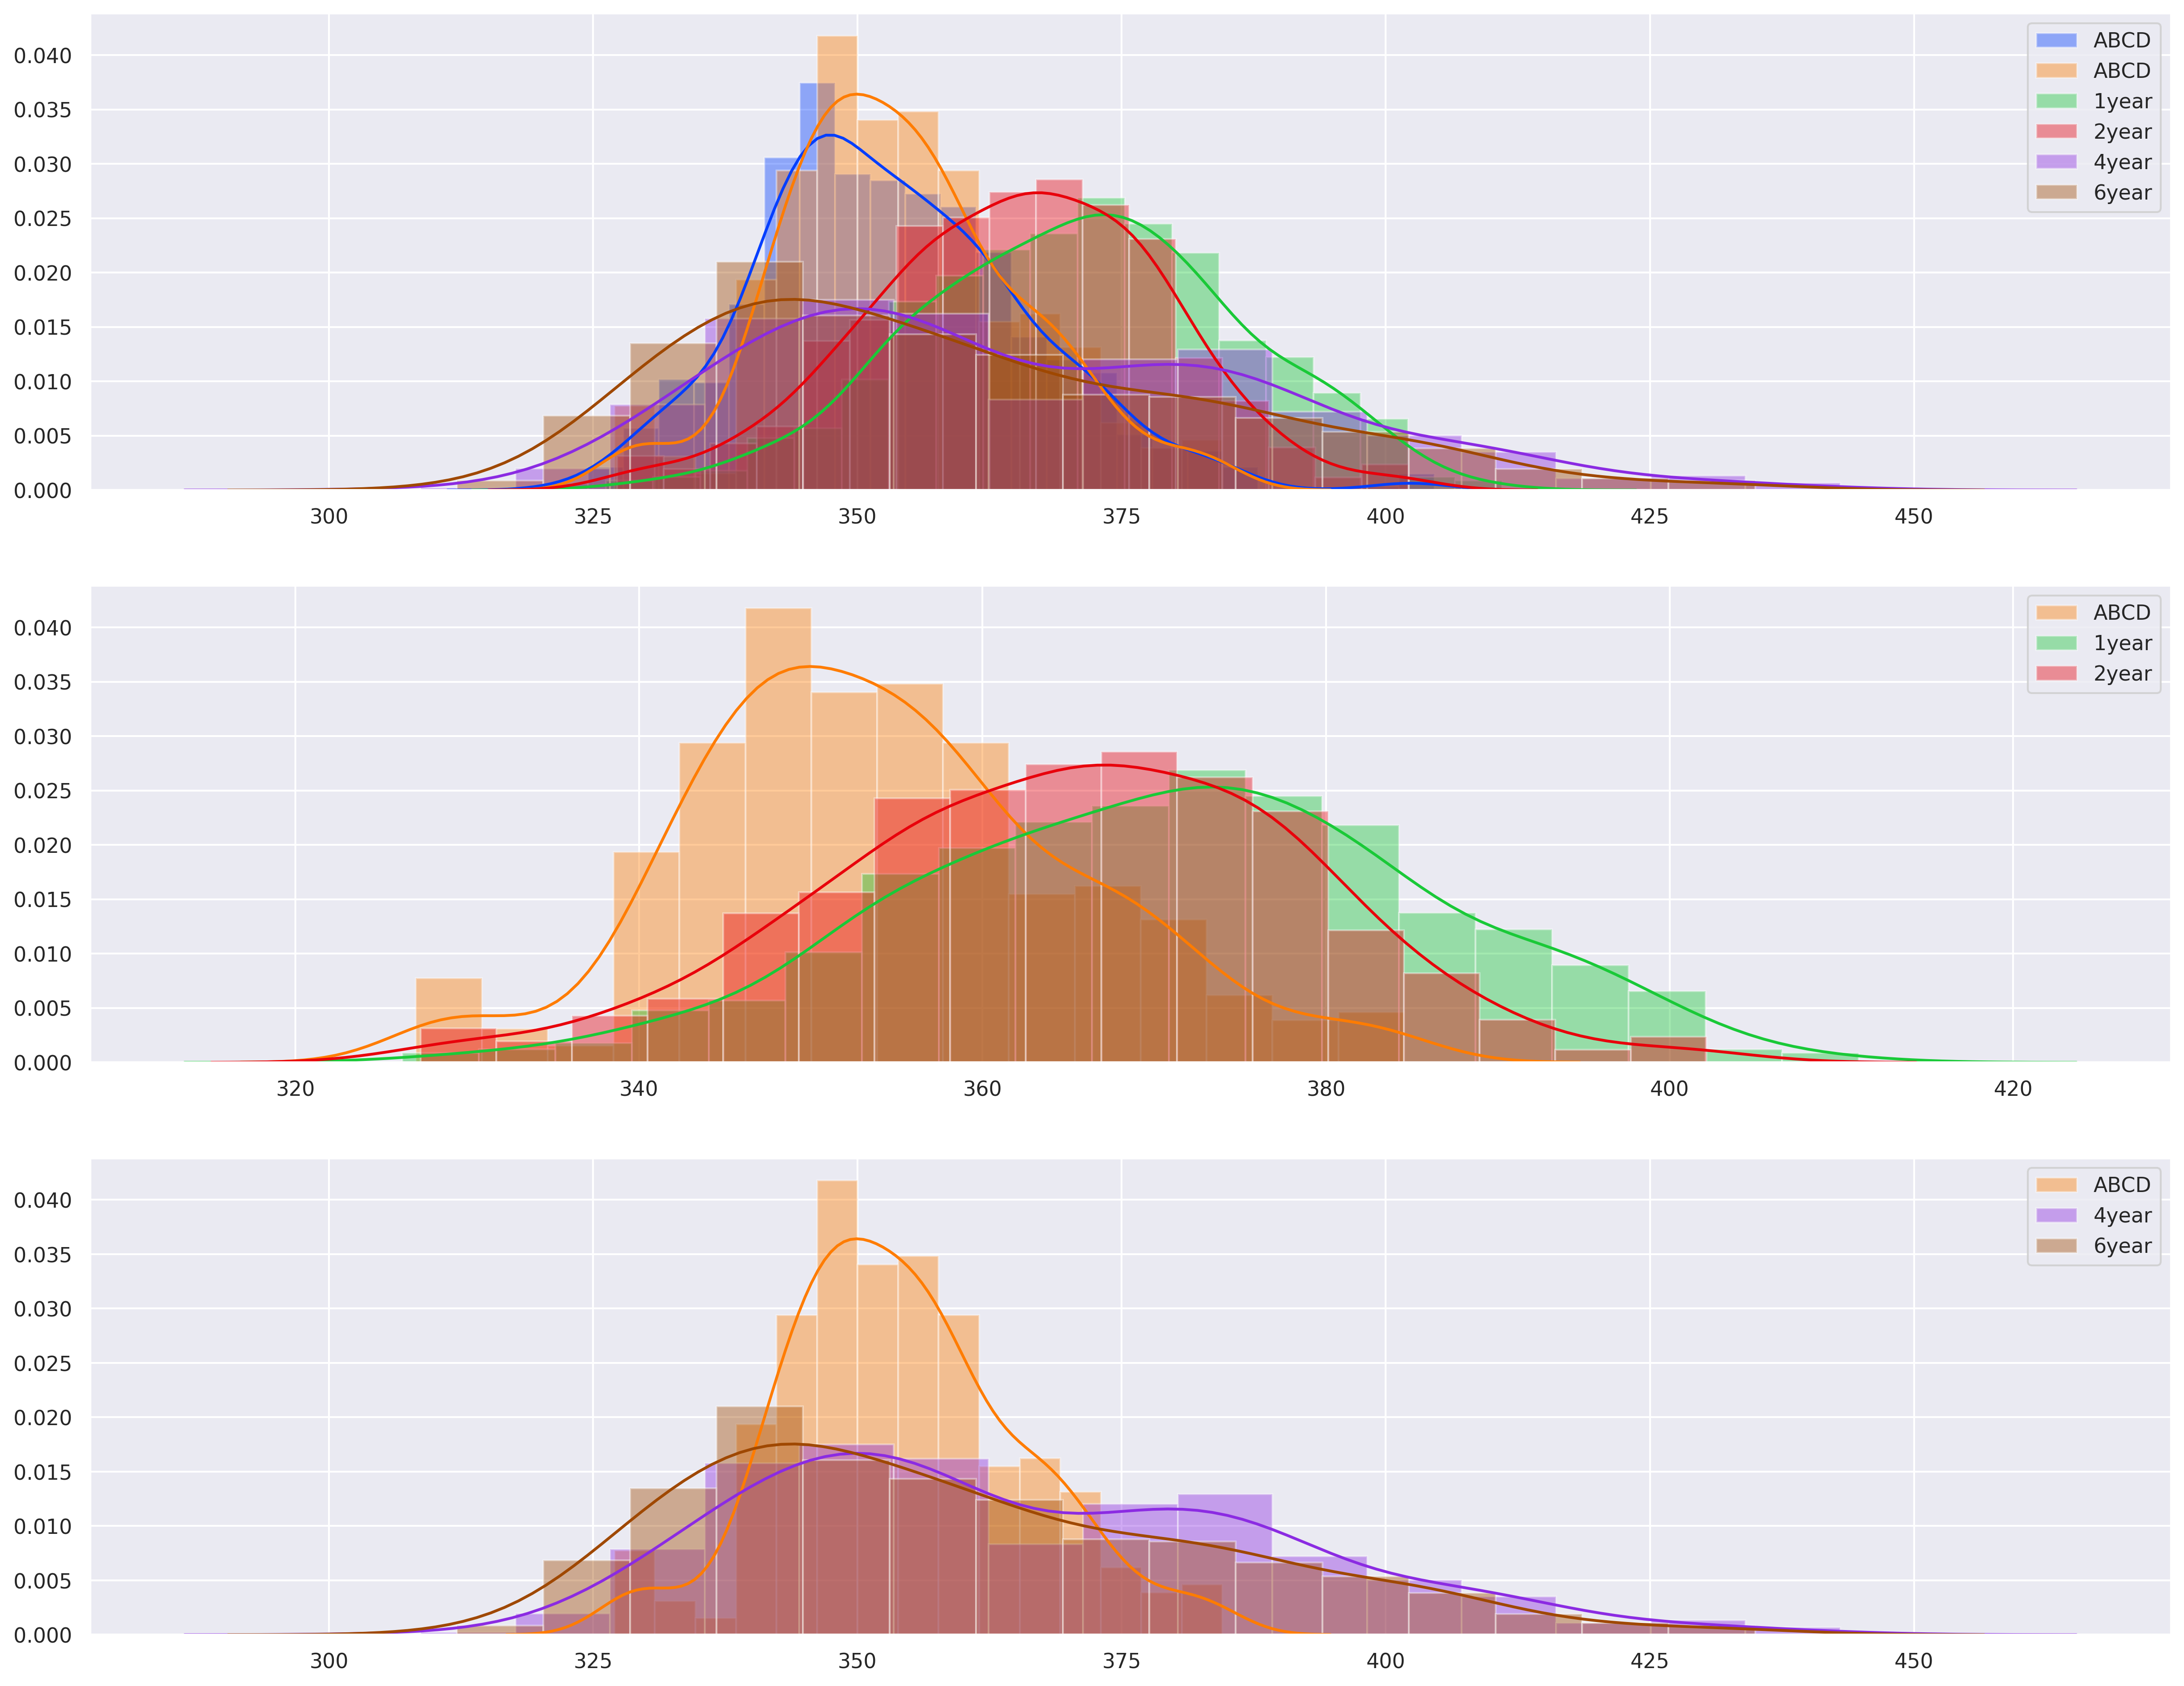

In [173]:
COLORS = sns.color_palette("bright")
# COLORS[0] = "blue" 
# COLORS[1] = "red" 

fig, axs = plt.subplots(3,1, figsize=(20,16))

sns.distplot(train_score, color=COLORS[0], label=LABELS[1], ax=axs[0])
sns.distplot(inlier_score, color=COLORS[1], label=LABELS[1], ax=axs[0])

for idx, _score in enumerate(outlier_scores):
    idx += 2
    sns.distplot(_score, color=COLORS[idx], label=LABELS[idx], ax=axs[0])

sns.distplot(inlier_score, color=COLORS[1], label=LABELS[1], ax=axs[1])
for idx, _score in enumerate(outlier_scores[:2]):
    idx += 2
    sns.distplot(_score, color=COLORS[idx], label=LABELS[idx], ax=axs[1])    

sns.distplot(inlier_score, color=COLORS[1], label=LABELS[1], ax=axs[2])
for idx, _score in enumerate(outlier_scores[2:]):
    idx += 4
    sns.distplot(_score, color=COLORS[idx], label=LABELS[idx], ax=axs[2])

for ax in axs: ax.legend()
plt.show()

**ABCD vs 1-year**

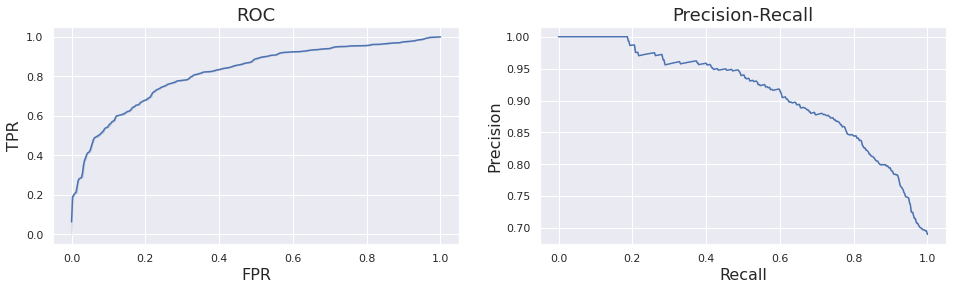

Inlier vs Outlier
----------------
ROC-AUC: 0.8178
PR-AUC: 0.9118
Avg Prec: 0.9118


In [65]:
metrics(inlier_score, outlier_scores[0], plot=True, verbose=True)
plt.show()

**ABCD vs 6-year**

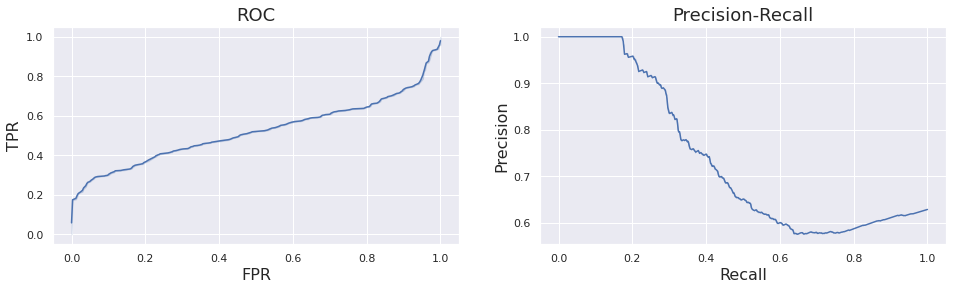

Inlier vs Outlier
----------------
ROC-AUC: 0.5217
PR-AUC: 0.7377
Avg Prec: 0.7380


In [72]:
metrics(inlier_score, outlier_scores[-1], plot=True, verbose=True)
plt.show()

In [73]:
# TODO: Plot all PR curves on one plot

In [ ]:
def metrics_multiplot(inlier_score, outlier_scores, plot=False, verbose=False):
    import numpy as np
    import seaborn as sns
    from sklearn.metrics import roc_curve
    from sklearn.metrics import classification_report, average_precision_score
    from sklearn.metrics import roc_auc_score, precision_recall_curve, auc
    
    fig, axs = plt.subplots(1,2, figsize=(16,4))
    
    y_true = np.concatenate((np.zeros(len(inlier_score)),
                             np.ones(len(outlier_score))))
    y_scores = np.concatenate((inlier_score, outlier_score))
    
    prec,rec,thresh = precision_recall_curve(y_true, y_scores)
    fpr, tpr, thresholds = roc_curve(y_true, y_scores)
    
    roc_auc = roc_auc_score(y_true,y_scores)
    pr_auc = auc(rec,prec)
    ap = average_precision_score(y_true,y_scores)
    
    if plot:    
    
        fig, axs = plt.subplots(1,2, figsize=(16,4))

        sns.lineplot(fpr, tpr, ax=axs[0])
        axs[0].set(
            xlabel="FPR", ylabel="TPR", title="ROC"
        )

        sns.lineplot(rec, prec, ax=axs[1])
        axs[1].set(
            xlabel="Recall", ylabel="Precision", title="Precision-Recall"
        )

        plt.show()
        plt.close()
    
    if verbose:
        print("Inlier vs Outlier")
        print("----------------")
        print("ROC-AUC: {:.4f}".format(roc_auc))
        print("PR-AUC: {:.4f}".format(pr_auc))
        print("Avg Prec: {:.4f}".format(ap))
        
    return roc_auc, ap, pr_auc

## Train Data = L2-norm(Pixel Scores)

In [88]:
%%time
inlier_train_dist = compute_scores(inlier_batches[:-1])
inlier_test_dist = compute_scores(inlier_batches[-1:])

Sigma: 0.0100: 100%|██████████| 10/10 [00:10<00:00,  1.05s/it]

CPU times: user 27.6 s, sys: 22 s, total: 49.6 s
Wall time: 1min 32s


In [89]:
%%time
train_data, test_data = [], []
outlier_norms = []

for x, s in enumerate(SIGMAS):
    train_data.append(tf.norm(inlier_train_dist[x] * s, axis=[1,2], ord="euclidean").numpy())
    test_data.append(tf.norm(inlier_test_dist[x] * s, axis=[1,2], ord="euclidean").numpy())
train_data = np.concatenate(train_data, axis=1)
test_data = np.concatenate(test_data, axis=1)

for _dists in outlier_dists:
    norms = [tf.norm(_dists[x] * s, axis=[1,2]).numpy() for x, s in enumerate(SIGMAS)]
    outlier_norms.append( np.concatenate(norms, axis=1))

CPU times: user 93.4 ms, sys: 53.1 ms, total: 147 ms
Wall time: 581 ms


In [90]:
train_data.shape, test_data.shape, [x.shape for x in outlier_norms]

((1000, 10), (137, 10), [(750, 10), (580, 10), (510, 10), (570, 10)])

In [91]:
X_train, X_test = train_data, test_data

### OC-SVM

In [92]:
from sklearn import svm
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from helper import plot_confusion_matrix

In [93]:
%%time
clf = svm.OneClassSVM(nu=0.01, kernel="rbf")
clf.fit(train_data)

CPU times: user 3.49 ms, sys: 1.59 ms, total: 5.08 ms
Wall time: 3.76 ms


OneClassSVM(nu=0.01)

In [95]:
y_true = np.concatenate((np.zeros(len(test_data)),
                         np.ones(len(outlier_norms[0]))))

# Rescaling: 0 = inlier , 1 = outlier
test_pred = (1-clf.predict(test_data)) // (2)
outlier_pred = (1-clf.predict(outlier_norms[0])) // 2
y_pred = np.concatenate((test_pred, outlier_pred))

print(classification_report(y_true, y_pred, target_names=["Inlier","1-Year"]))

              precision    recall  f1-score   support

      Inlier       0.41      1.00      0.58       137
      1-Year       1.00      0.74      0.85       750

    accuracy                           0.78       887
   macro avg       0.71      0.87      0.72       887
weighted avg       0.91      0.78      0.81       887



> **Low precision => Low PPV => High False Positives**

In [84]:
y_true = np.concatenate((np.zeros(len(test_data)),
                         np.ones(len(outlier_data_2))))

# Rescaling: 0 = inlier , 1 = outlier
outlier_pred = (1-clf.predict(outlier_data_2)) // 2
y_pred = np.concatenate((test_pred, outlier_pred))

print(classification_report(y_true, y_pred, target_names=["Inlier","4-Year"]))

              precision    recall  f1-score   support

      Inlier       0.53      1.00      0.70       337
      4-Year       1.00      0.49      0.66       580

    accuracy                           0.68       917
   macro avg       0.77      0.75      0.68       917
weighted avg       0.83      0.68      0.67       917



### Grid Search
> **Defaults w/ rbf seem to work best**

In [85]:
y_train = np.ones(len(train_data))

params = {"nu":[0.01, 0.02, 0.001],
          "gamma": ["scale", "auto"],
          "shrinking": [True, False],
          "kernel": ["rbf", "poly", "sigmoid"]
         }

grid = GridSearchCV(estimator=svm.OneClassSVM(), param_grid=params, n_jobs=12,
                    cv=10, scoring="precision", verbose=1)
print(grid)

GridSearchCV(cv=10, estimator=OneClassSVM(), n_jobs=12,
             param_grid={'gamma': ['scale', 'auto'],
                         'kernel': ['rbf', 'poly', 'sigmoid'],
                         'nu': [0.01, 0.02, 0.001],
                         'shrinking': [True, False]},
             scoring='precision', verbose=1)


In [86]:
%%time
grid.fit(train_data, y_train)

Fitting 10 folds for each of 36 candidates, totalling 360 fits


[Parallel(n_jobs=12)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  27 tasks      | elapsed:    1.2s


CPU times: user 535 ms, sys: 1.12 s, total: 1.66 s
Wall time: 1.83 s


[Parallel(n_jobs=12)]: Done 337 out of 360 | elapsed:    1.8s remaining:    0.1s
[Parallel(n_jobs=12)]: Done 360 out of 360 | elapsed:    1.8s finished


GridSearchCV(cv=10, estimator=OneClassSVM(), n_jobs=12,
             param_grid={'gamma': ['scale', 'auto'],
                         'kernel': ['rbf', 'poly', 'sigmoid'],
                         'nu': [0.01, 0.02, 0.001],
                         'shrinking': [True, False]},
             scoring='precision', verbose=1)

In [87]:
grid.best_params_

{'gamma': 'scale', 'kernel': 'rbf', 'nu': 0.01, 'shrinking': True}

In [88]:
%%time

clf = svm.OneClassSVM(**grid.best_params_)
clf.fit(train_data)

y_true = np.concatenate((np.zeros(len(test_data)),
                         np.ones(len(outlier_data_1))))

# Rescaling: 0 = inlier , 1 = outlier
test_pred = (1-clf.predict(test_data)) // (2)
outlier_pred = (1-clf.predict(outlier_data_1)) // 2
y_pred = np.concatenate((test_pred, outlier_pred))

print(classification_report(y_true, y_pred, target_names=["Inlier","1-Year"]))

              precision    recall  f1-score   support

      Inlier       0.69      1.00      0.81       337
      1-Year       1.00      0.74      0.85       580

    accuracy                           0.83       917
   macro avg       0.84      0.87      0.83       917
weighted avg       0.89      0.83      0.84       917

CPU times: user 12.3 ms, sys: 1.8 ms, total: 14.1 ms
Wall time: 11.8 ms


Confusion matrix, without normalization
[[1.        0.       ]
 [0.2637931 0.7362069]]
Overall Accuracy: 0.8332


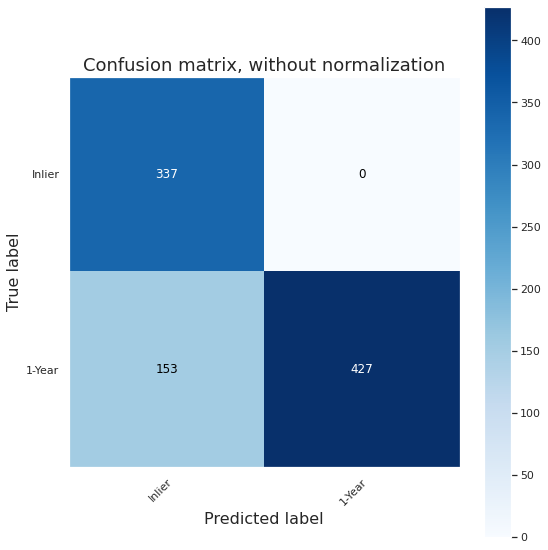

In [89]:
plot_confusion_matrix(y_true, y_pred, classes=["Inlier","1-Year"])
plt.grid(False)

## GMM

In [96]:
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

In [127]:
%%time
gmm_clf = Pipeline([
    ("scaler", StandardScaler()),
    ("GMM", GaussianMixture())
])

param_grid = dict(GMM__n_components = range(1,11),
                  GMM__covariance_type = ["full"])

grid = GridSearchCV(estimator=gmm_clf,
                    param_grid=param_grid,
                    cv=10, n_jobs=10,
                    verbose=1)

grid_result = grid.fit(train_data)

Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  40 tasks      | elapsed:    0.4s
[Parallel(n_jobs=10)]: Done 100 out of 100 | elapsed:    1.4s finished


CPU times: user 1.45 s, sys: 2.04 s, total: 3.5 s
Wall time: 1.62 s


In [128]:
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
print("-----"*15)
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 1.377808 using {'GMM__covariance_type': 'full', 'GMM__n_components': 2}
---------------------------------------------------------------------------
0.535935 (1.135704) with: {'GMM__covariance_type': 'full', 'GMM__n_components': 1}
1.377808 (1.005588) with: {'GMM__covariance_type': 'full', 'GMM__n_components': 2}
1.289045 (1.159989) with: {'GMM__covariance_type': 'full', 'GMM__n_components': 3}
1.305611 (1.138710) with: {'GMM__covariance_type': 'full', 'GMM__n_components': 4}
1.244151 (1.311413) with: {'GMM__covariance_type': 'full', 'GMM__n_components': 5}
1.029289 (1.411533) with: {'GMM__covariance_type': 'full', 'GMM__n_components': 6}
0.884763 (1.557486) with: {'GMM__covariance_type': 'full', 'GMM__n_components': 7}
0.856655 (1.574422) with: {'GMM__covariance_type': 'full', 'GMM__n_components': 8}
0.703584 (1.573102) with: {'GMM__covariance_type': 'full', 'GMM__n_components': 9}
0.356764 (1.873824) with: {'GMM__covariance_type': 'full', 'GMM__n_components': 10}


In [129]:
best_params = grid.best_params_

best_gmm_clf = Pipeline([
    ("scaler", StandardScaler()),
    ("GMM", GaussianMixture())
]).set_params(**best_params)

best_gmm_clf.fit(X_train)

print("Training Likelihood: {:.3f}".format(best_gmm_clf.score(X_train)))
print("Testing Likelihood: {:.3f}".format(best_gmm_clf.score(X_test)))
print("1-year Likelihood: {:.3f}".format(best_gmm_clf.score(outlier_norms[0])))
print("2-year Likelihood: {:.3f}".format(best_gmm_clf.score(outlier_norms[1])))

Training Likelihood: 1.768
Testing Likelihood: 1.929
1-year Likelihood: -42.646
2-year Likelihood: -36.656


In [178]:
train_score = -best_gmm_clf.score_samples(X_train)
test_score = -best_gmm_clf.score_samples(X_test)
outlier_scores = []
for data in outlier_norms:
    outlier_scores.append(-best_gmm_clf.score_samples(data))

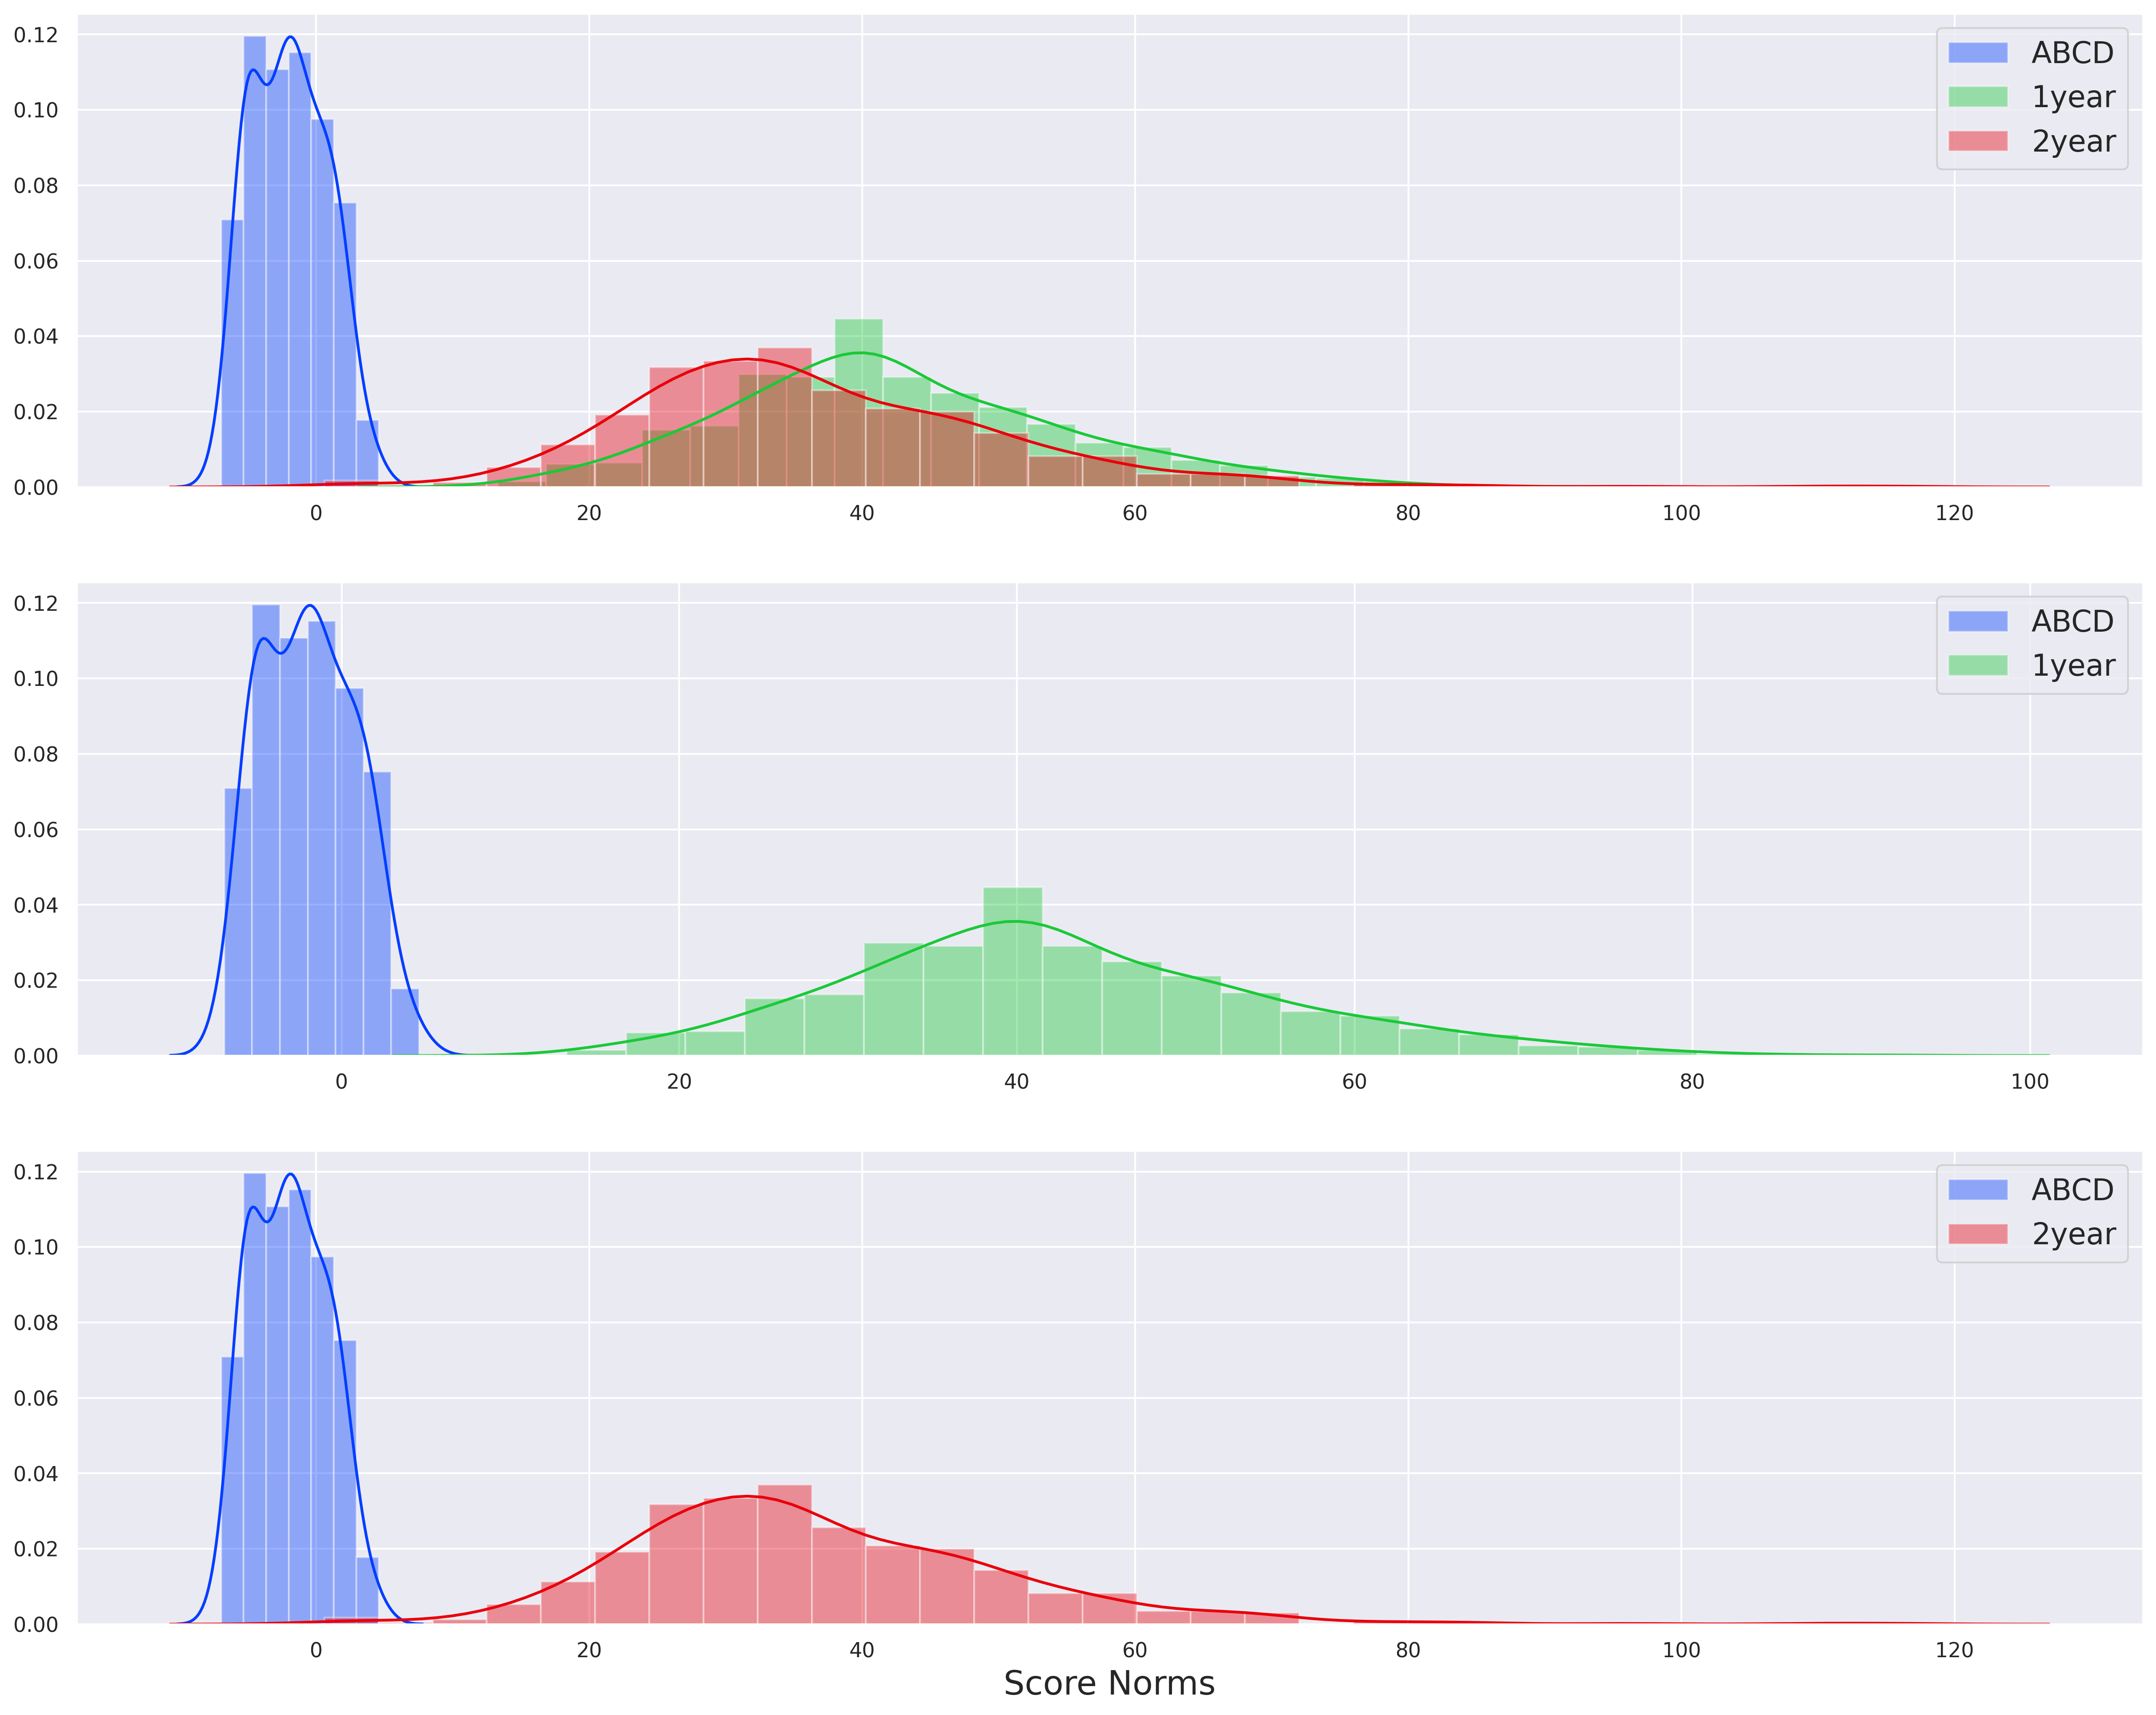

In [180]:
COLORS = sns.color_palette("bright")
# COLORS[0] = "blue" 
# COLORS[1] = "red" 

fig, axs = plt.subplots(3,1, figsize=(20,16))

# sns.distplot(train_score, color=COLORS[0], label=LABELS[0], ax=axs[0])
sns.distplot(test_score, color=COLORS[0], label=LABELS[1], ax=axs[0])

for idx, _score in enumerate(outlier_scores[:2]):
    idx += 2
    sns.distplot(_score, color=COLORS[idx], label=LABELS[idx], ax=axs[0])

sns.distplot(test_score, color=COLORS[0], label=LABELS[1], ax=axs[1])
for idx, _score in enumerate(outlier_scores[:1]):
    idx += 2
    sns.distplot(_score, color=COLORS[idx], label=LABELS[idx], ax=axs[1])    

sns.distplot(test_score, color=COLORS[0], label=LABELS[1], ax=axs[2])
for idx, _score in enumerate(outlier_scores[1:2]):
    idx += 3
    sns.distplot(_score, color=COLORS[idx], label=LABELS[idx], ax=axs[2])

for ax in axs: ax.legend(fontsize=16)
axs[-1].set(xlabel="Score Norms")
plt.show()

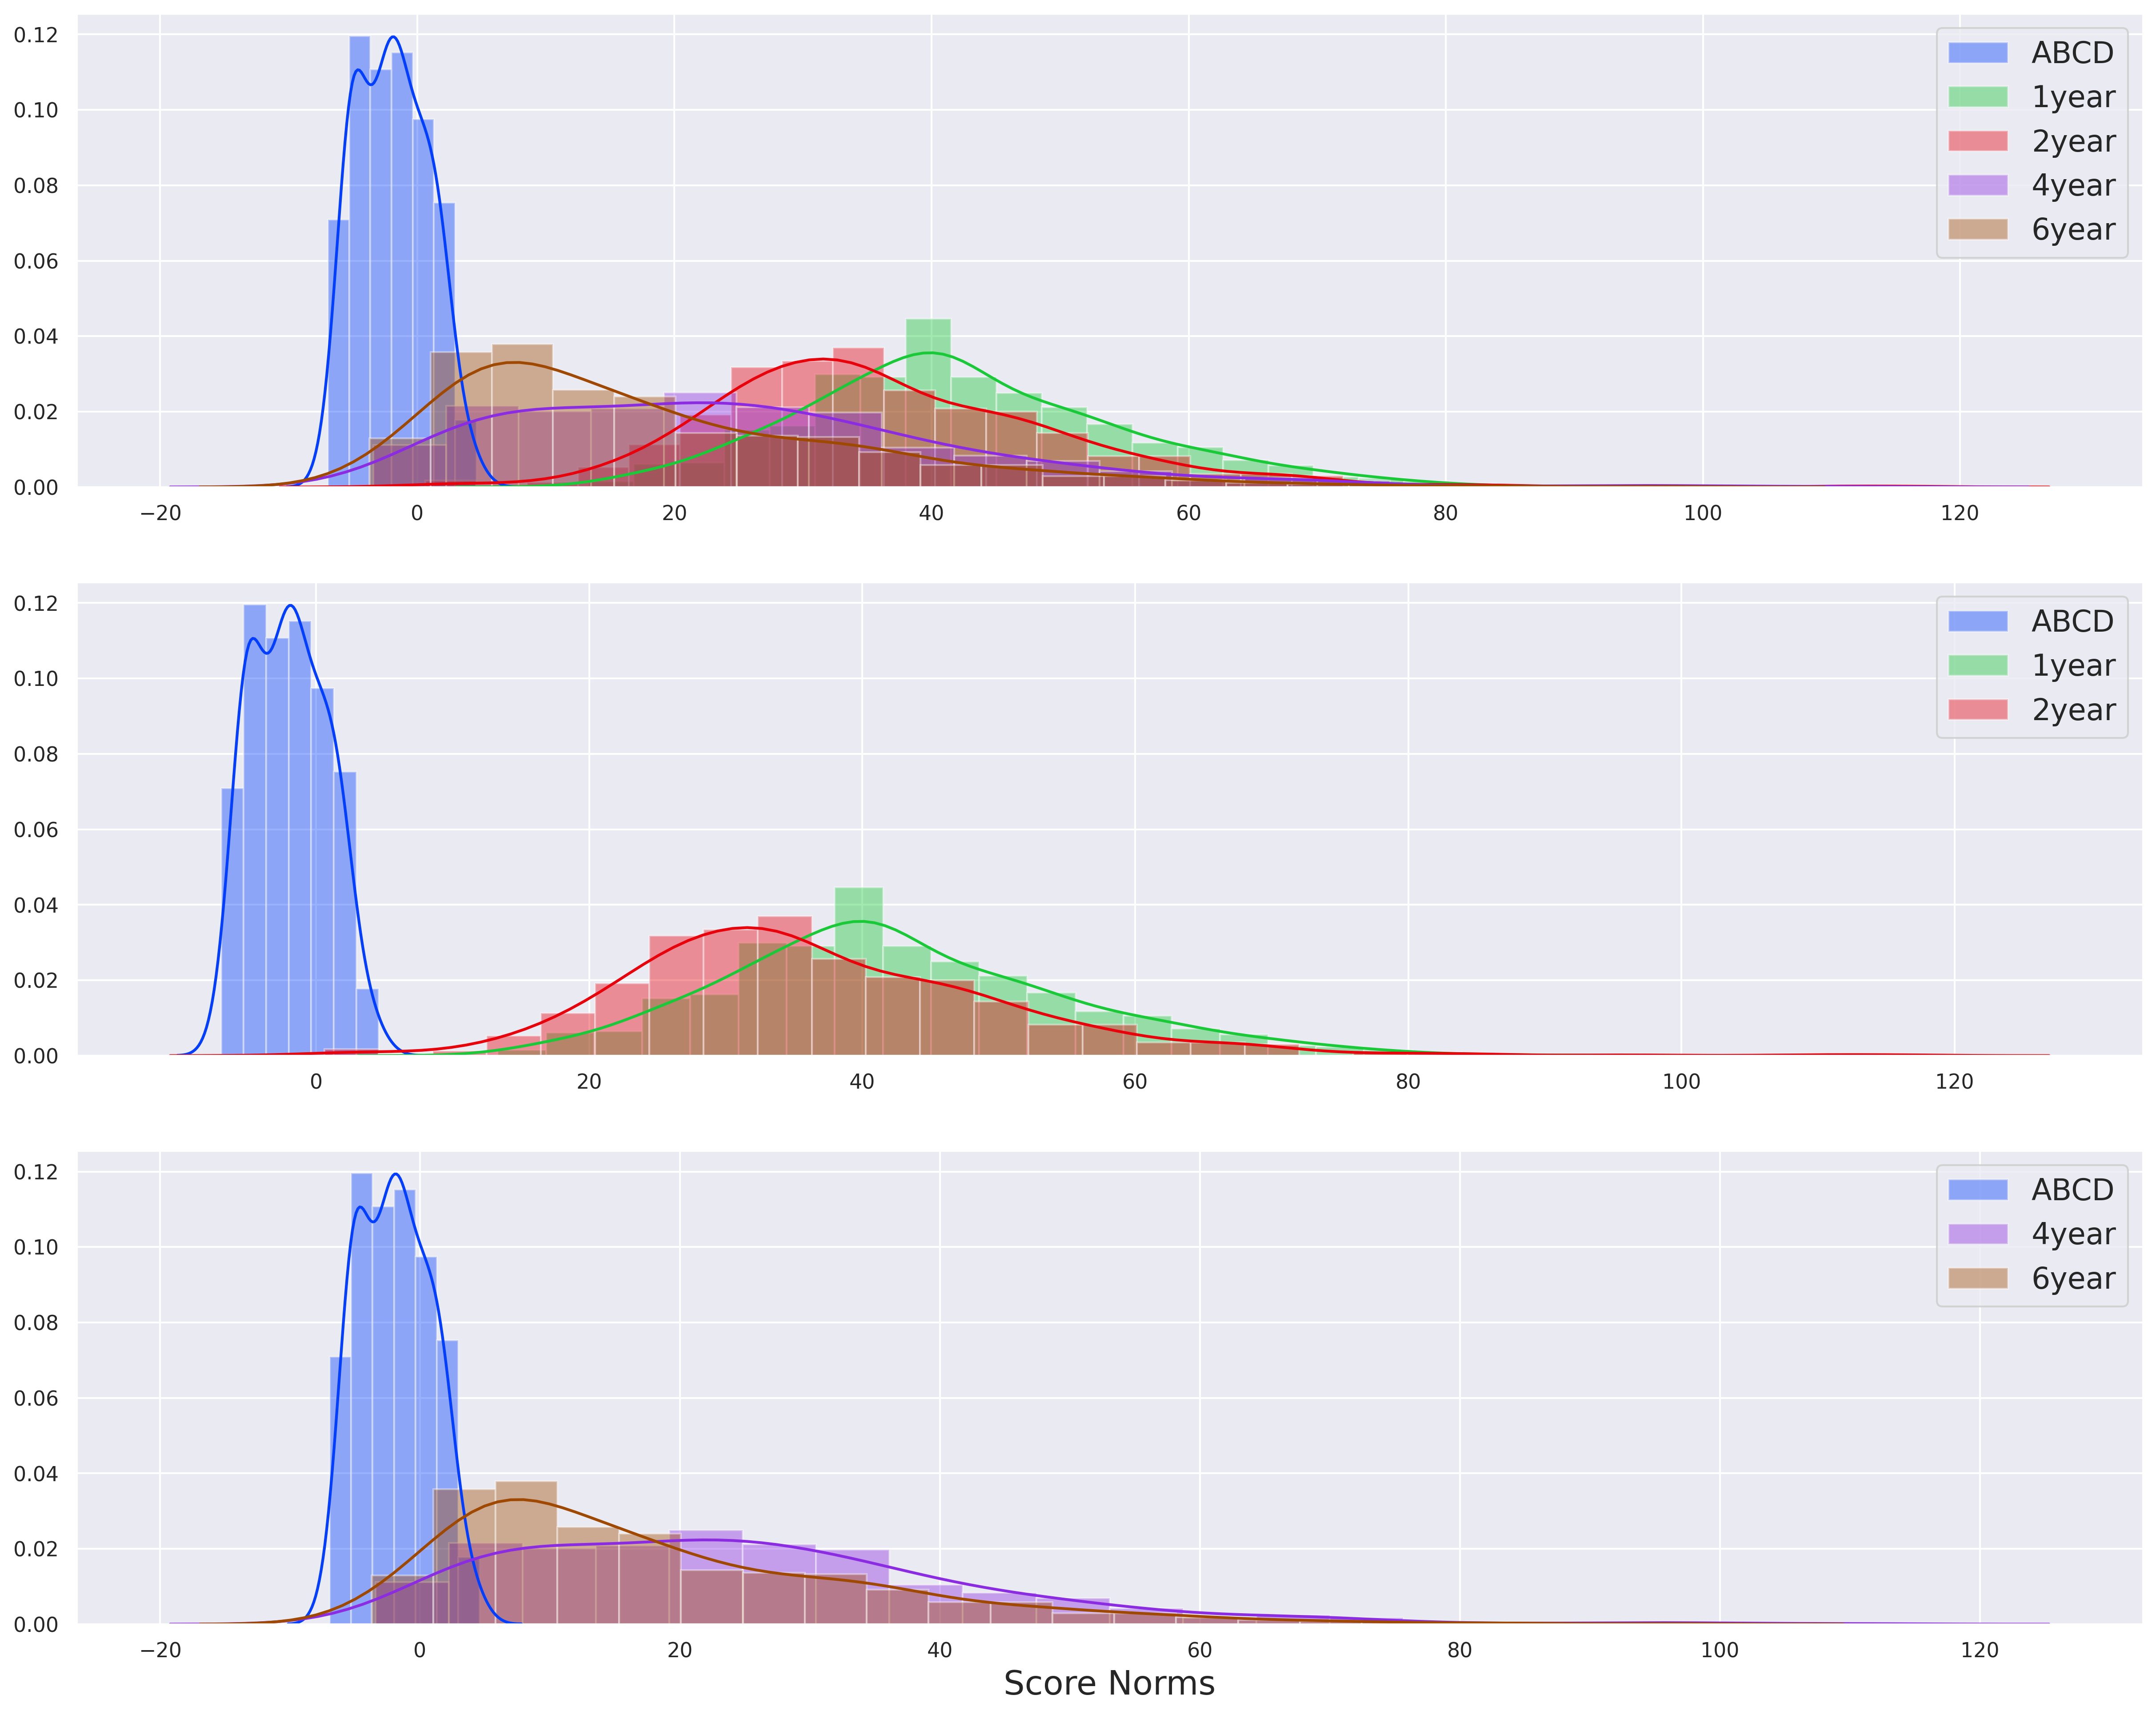

In [182]:
fig, axs = plt.subplots(3,1, figsize=(20,16))

# sns.distplot(train_score, color=COLORS[0], label=LABELS[1], ax=axs[0])
sns.distplot(test_score, color=COLORS[0], label=LABELS[1], ax=axs[0])

for idx, _score in enumerate(outlier_scores):
    idx += 2
    sns.distplot(_score, color=COLORS[idx], label=LABELS[idx], ax=axs[0])

sns.distplot(test_score, color=COLORS[0], label=LABELS[1], ax=axs[1])
for idx, _score in enumerate(outlier_scores[:2]):
    idx += 2
    sns.distplot(_score, color=COLORS[idx], label=LABELS[idx], ax=axs[1])    

sns.distplot(test_score, color=COLORS[0], label=LABELS[1], ax=axs[2])
for idx, _score in enumerate(outlier_scores[2:]):
    idx += 4
    sns.distplot(_score, color=COLORS[idx], label=LABELS[idx], ax=axs[2])

for ax in axs: ax.legend(fontsize=16)
axs[-1].set(xlabel="Score Norms")

plt.show()

# Could do PCA of covariance matrix of each component - best_gmm_clf[].covariances_
# Look at different eigen vectors / values of each component 

**ABCD vs 1-year**

In [109]:
metrics(-test_score, -outlier_scores[0], plot=False, verbose=True)
plt.show()

Inlier vs Outlier
----------------
ROC-AUC: 1.0000
PR-AUC: 1.0000
Avg Prec: 1.0000


**ABCD vs 6-year**

In [110]:
metrics(-test_score, -outlier_scores[-1], plot=False, verbose=True)
plt.show()

Inlier vs Outlier
----------------
ROC-AUC: 0.9692
PR-AUC: 0.9930
Avg Prec: 0.9930


0: -1.396130 using {'GMM__covariance_type': 'full', 'GMM__n_components': 3}
1: -1.408392 using {'GMM__covariance_type': 'full', 'GMM__n_components': 3}
2: -1.405110 using {'GMM__covariance_type': 'full', 'GMM__n_components': 4}
3: -1.427869 using {'GMM__covariance_type': 'full', 'GMM__n_components': 1}
4: -1.425087 using {'GMM__covariance_type': 'full', 'GMM__n_components': 2}
5: -1.425599 using {'GMM__covariance_type': 'full', 'GMM__n_components': 1}
6: -1.410634 using {'GMM__covariance_type': 'full', 'GMM__n_components': 3}
7: -1.414108 using {'GMM__covariance_type': 'full', 'GMM__n_components': 3}
8: -1.419498 using {'GMM__covariance_type': 'full', 'GMM__n_components': 6}
9: -1.417428 using {'GMM__covariance_type': 'full', 'GMM__n_components': 3}


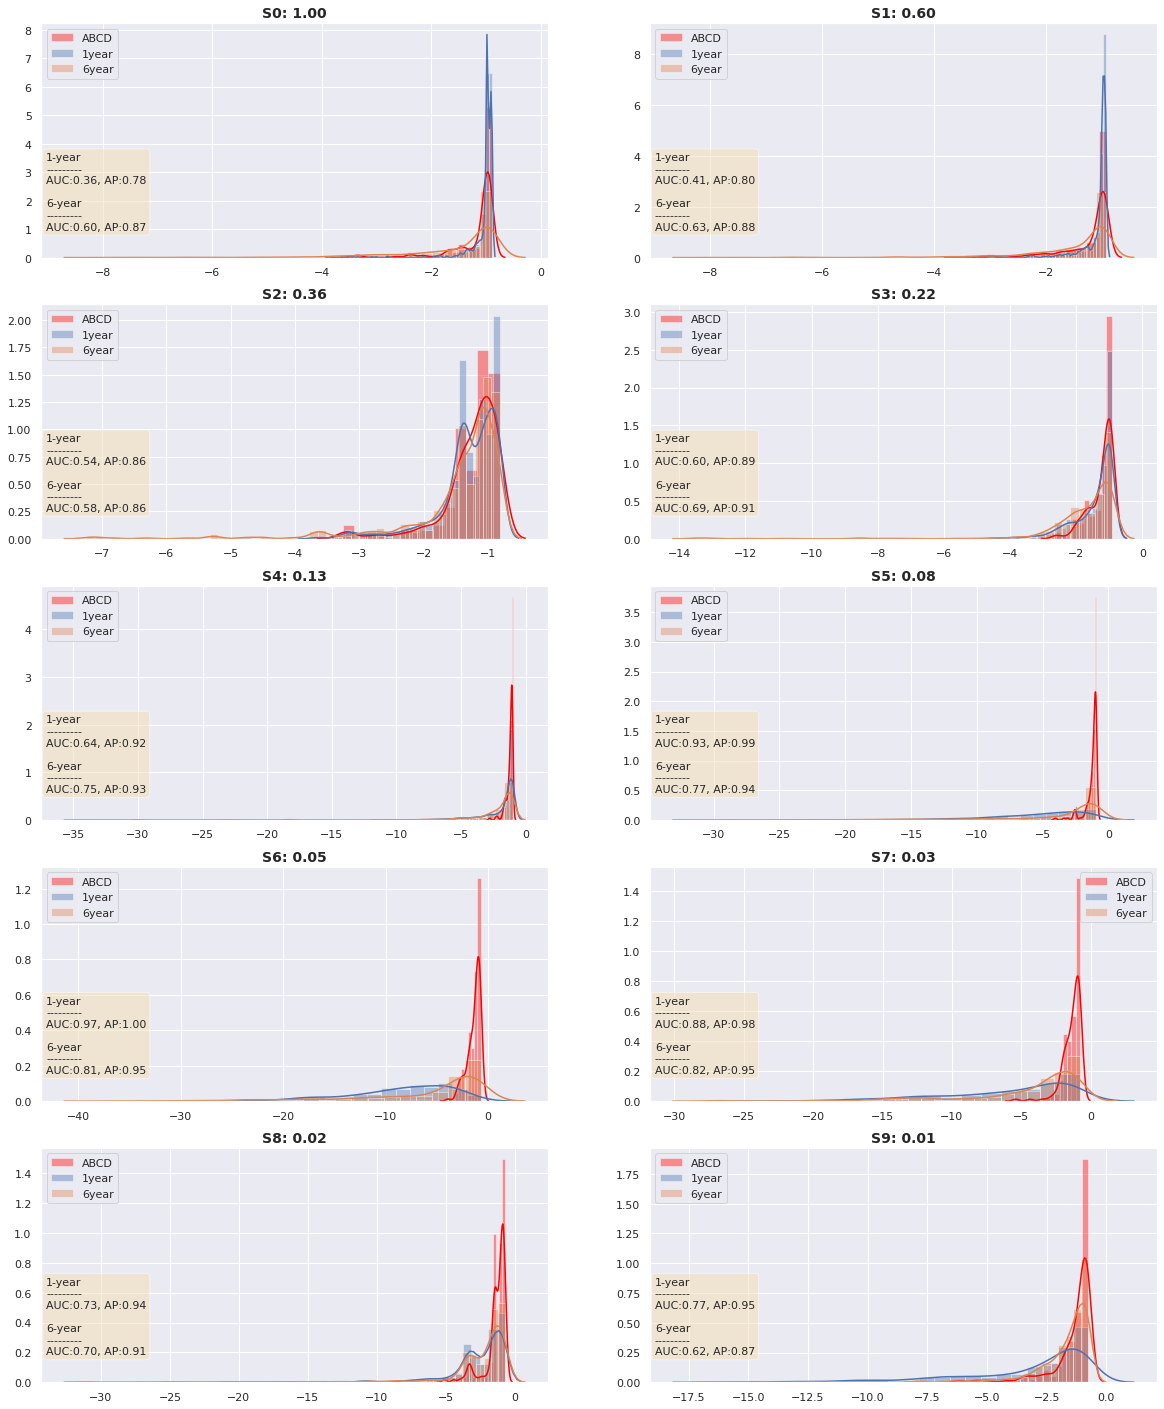

In [125]:
# progress_bar = tqdm(sigmas, desc='Sigma: ?')
fig, axs = plt.subplots(5,2, figsize=(20,25))
axs = axs.flatten()

for idx, sigma in enumerate(SIGMAS):
    _x_train = train_data[:, idx:idx+1]
    _x_test = test_data[:, idx:idx+1]
    _yr1 = outlier_norms[0][:, idx:idx+1]
    _yr2 = outlier_norms[-1][:, idx:idx+1]
    
    gmm_clf = Pipeline([
        ("scaler", StandardScaler()),
        ("GMM", GaussianMixture())
    ])
    
    
    # Each sigma gets its own hyperparameter-tuned model
    param_grid = dict(GMM__n_components = range(1,11),
                      GMM__covariance_type = ["full"])

    grid = GridSearchCV(estimator=gmm_clf,
                        param_grid=param_grid,
                        cv=10, n_jobs=10)
    grid_result = grid.fit(_x_train)
    print("%d: %f using %s" % (idx, grid_result.best_score_, grid_result.best_params_))
    
    
    best_gmm_clf = gmm_clf.set_params(**grid.best_params_)
    best_gmm_clf.fit(_x_train)
    
    _train_score = best_gmm_clf.score_samples(_x_train)
    _inlier_score = best_gmm_clf.score_samples(_x_test)
    yr1_score = best_gmm_clf.score_samples(_yr1)
    yr2_score = best_gmm_clf.score_samples(_yr2)

#     sns.distplot(_train_score, label="Training", ax=axs[idx])
    sns.distplot(_inlier_score, color="red", label=labels[0], ax=axs[idx])
    sns.distplot(yr1_score, label=LABELS[2], ax=axs[idx])
    sns.distplot(yr2_score, label=LABELS[-1], ax=axs[idx])

    textstr = '\n'.join((
        '1-year',
        "---------",
        'AUC:%.2f, AP:%.2f' % (metrics(-_inlier_score, -yr1_score)[:-1]),
        '',
        '6-year',
        "---------",
        'AUC:%.2f, AP:%.2f' % (metrics(-_inlier_score, -yr2_score)[:-1])))

    # these are matplotlib.patch.Patch properties
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)

    # place a text box in upper left in axes coords
    axs[idx].text(0.01, 0.45, textstr, transform=axs[idx].transAxes, fontsize=11,
            verticalalignment='top', bbox=props)
    
    axs[idx].set_title("S{:d}: {:.2f}".format(idx, sigma), fontsize=14, fontweight="bold")  
    
    axs[idx].legend()

plt.show()

> **S6 shows the best separation**